# Preface

Алгоритмы **квантовых вычислений** изучены далеко не так хорошо как классические алгоритмы. Но они демонстрируют высокий потенциал, и программнные инструменты для их реализации уже доступны разработчикам. Чтобы познакомиться с данными инструментами, а также оценить эффективность решений предоставляемых квантовыми вычислениями для сферы финтеха, мы реализуем несколько алгоритмов.

# QAOA vs ?

## Dataset - S&P 500 stock data

### Описание

[Данный датасет](https://www.kaggle.com/datasets/camnugent/sandp500/data) представляет собой данные за пять лет по рынку акций списка [S&P 500](https://stockanalysis.com/list/sp-500-stocks/).

### Содержание

Файл данных содержит следующие колонки:

- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD Billions)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Volume - Number of shares traded
- Name - the stock's ticker name

### Предобработка

### Выбор пула стоков

Современные NISQ системы показывают приемлимые результаты для данной модели в пределе пула размером 20, поэтому мы ограничимся таким числом.
В целях исследования, разобъем исследуемые данные на три группы - по максимальному достигнутому значению цены акции (High) для каждой компании (Name). Выберем интервал 'до \\$30B', 'от \\$30B до \\$100B', и 'от \\$100B'. В первых двух интервалах выберем по пять компаний, в последнем десять.

In [2]:
import pandas as pd
pf_df = pd.read_csv('./datasets/all_stocks_5yr.csv')

In [3]:
pf_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  str    
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  str    
dtypes: float64(4), int64(1), str(2)
memory usage: 33.1 MB


In [4]:
pf_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [5]:
pf_df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [6]:
# Уберем из списка стоки с NA данными
pf_df.drop(pf_df.loc[pf_df['open'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['high'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['low'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)

In [7]:
# Преобразование типов
pf_df = pf_df.convert_dtypes()

In [8]:
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  string 
 1   open    619029 non-null  Float64
 2   high    619029 non-null  Float64
 3   low     619029 non-null  Float64
 4   close   619029 non-null  Float64
 5   volume  619029 non-null  Int64  
 6   Name    619029 non-null  string 
dtypes: Float64(4), Int64(1), string(2)
memory usage: 40.7 MB


In [9]:
pf_df['date'] = pd.to_datetime(pf_df['date'])
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[us]
 1   open    619029 non-null  Float64       
 2   high    619029 non-null  Float64       
 3   low     619029 non-null  Float64       
 4   close   619029 non-null  Float64       
 5   volume  619029 non-null  Int64         
 6   Name    619029 non-null  string        
dtypes: Float64(4), Int64(1), datetime64[us](1), string(1)
memory usage: 40.7 MB


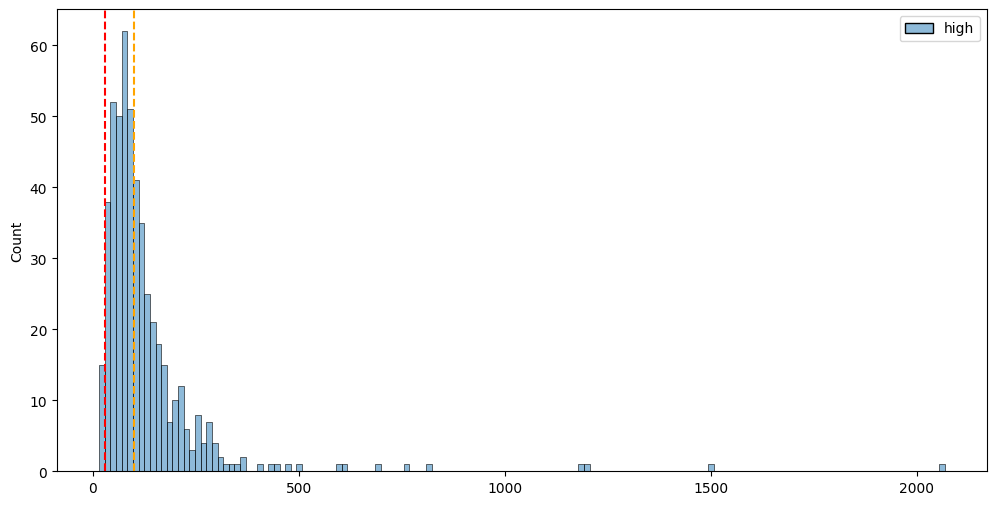

In [10]:
# Группы выбора на графике
import matplotlib.pyplot as plt
import seaborn as sns

high_max = pf_df[['high', 'Name']].groupby(['Name']).max()

_, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=high_max, bins=150, ax=ax)
plt.axvline(x=30, color='red', linestyle='--')
plt.axvline(x=100, color='orange', linestyle='--')
#TODO: use plotly or add plot without ouliers

In [11]:
pf_df1 = high_max[high_max['high'] <= 30].sample(5)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(5)
pf_df3 = high_max[high_max['high'] > 100].sample(10)
#pf_df3
#pf_df[pf_df['high']high_max < 30]
#high_max[high_max['high'] < 30].sample(5)
pf_df[pf_df['Name'].isin(pf_df1.index)]['date'].value_counts()

date
2014-04-17    5
2014-04-21    5
2014-04-22    5
2014-04-23    5
2014-04-24    5
             ..
2013-06-12    3
2013-06-13    3
2013-06-14    3
2013-06-17    3
2013-06-18    3
Name: count, Length: 1259, dtype: int64

<Axes: ylabel='Frequency'>

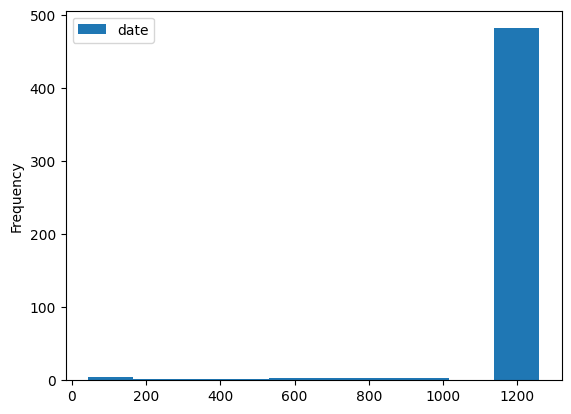

In [12]:
# Давайте узнаем как много организаций не имеют данных на полный период времени
pf_df[['date', 'Name']].groupby(['Name']).count().plot.hist()

In [13]:
# Попробуем использовать для исследования только полные данные.
dates = pf_df['date'].sort_values().unique()
pf_df = pf_df.groupby(['Name']).filter(lambda x: x['date'].count() == len(dates))
high_max = pf_df[['high', 'Name']].groupby(['Name']).max()
pf_df1 = high_max[high_max['high'] <= 30].sample(2, random_state=1)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(2, random_state=1)
pf_df3 = high_max[high_max['high'] > 100].sample(6, random_state=1)
pf20_df = pf_df[pf_df['Name'].isin(pf_df1.index)]
pf20_df['class'] = 'C'
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df2.index)]], ignore_index=True).fillna('B')
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df3.index)]], ignore_index=True).fillna('A')

Text(0.5, 0.925, 'Closing prices, $B')

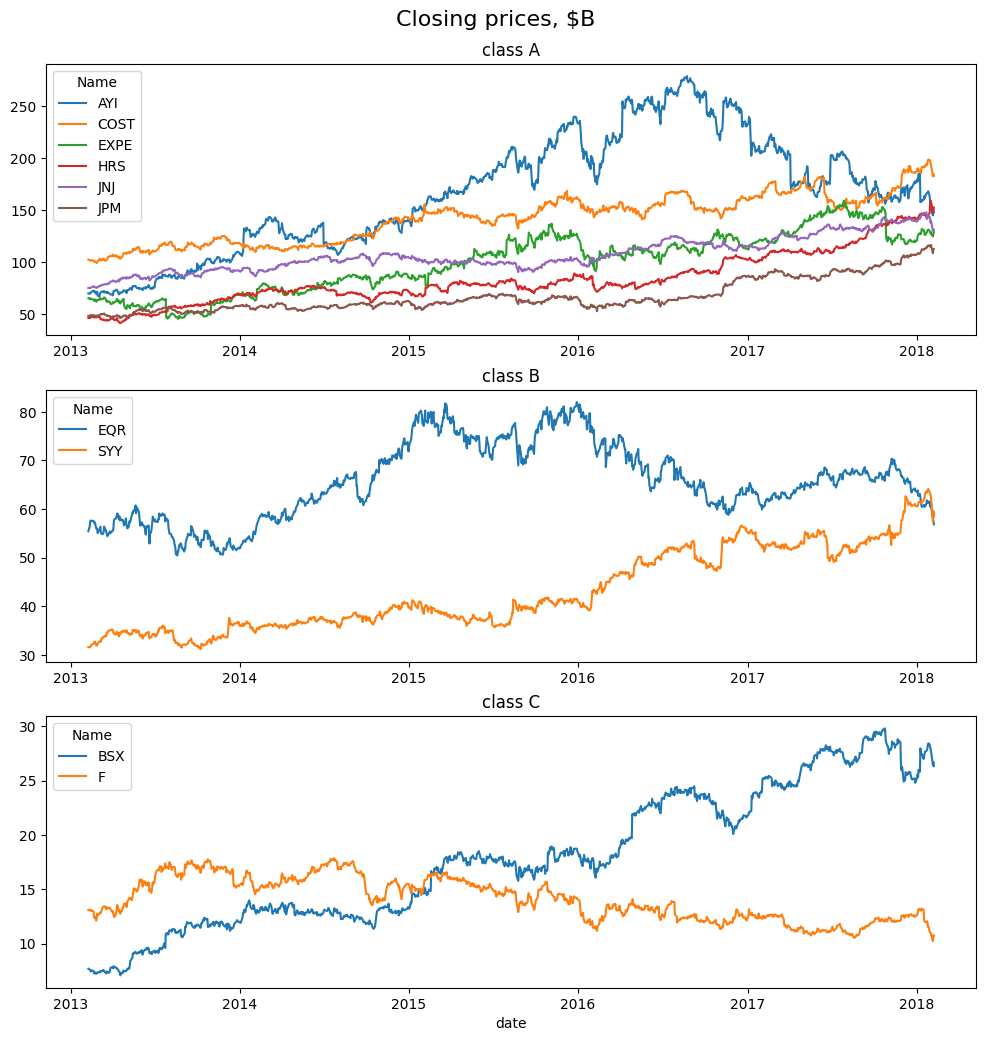

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(data=pf20_df[pf20_df['class'] == 'A'], x='date', y='close', hue='Name', ax=ax[0]).set(xlabel=None, ylabel=None, title='class A')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'B'], x='date', y='close', hue='Name', ax=ax[1]).set(xlabel=None, ylabel=None, title='class B')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'C'], x='date', y='close', hue='Name', ax=ax[2]).set(ylabel=None, title='class C')
fig.suptitle('Closing prices, $B', fontsize=16, y=0.925)
#g = sns.FacetGrid(pf20_df.sort_values('class'), row='class', aspect=4.)
#g.map(sns.lineplot, 'date', 'high', 'Name')
#g.add_legend()

In [15]:
#date80 = dates[int(0.8*len(dates))]
date_test  = max(dates) - pd.Timedelta(365, 'D')
pf20train_df = pf20_df[pf20_df['date'] <= date_test]
pf20test_df = pf20_df[pf20_df['date'] > date_test]
len(pf20train_df) + len(pf20test_df) == len(pf20_df)

True

In [16]:
pf20train_df = pf20train_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')
pf20test_df = pf20test_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')

In [17]:
pf20train_df
pf20_df['date'].value_counts()

date
2013-02-08    10
2013-02-11    10
2013-02-12    10
2013-02-13    10
2013-02-14    10
              ..
2018-02-01    10
2018-02-02    10
2018-02-05    10
2018-02-06    10
2018-02-07    10
Name: count, Length: 1259, dtype: int64

In [18]:
pd.Timestamp('2018-02-07') - pd.Timestamp('2013-02-08')

Timedelta('1825 days 00:00:00')

In [19]:
pf20_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 12590 entries, 0 to 12589
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12590 non-null  datetime64[us]
 1   open    12590 non-null  Float64       
 2   high    12590 non-null  Float64       
 3   low     12590 non-null  Float64       
 4   close   12590 non-null  Float64       
 5   volume  12590 non-null  Int64         
 6   Name    12590 non-null  string        
 7   class   12590 non-null  str           
dtypes: Float64(4), Int64(1), datetime64[us](1), str(1), string(1)
memory usage: 848.5 KB


In [20]:
# Вычислим дневную доходность
pf20train_df = pf20train_df.diff() / pf20train_df.shift(1)#.div(pf20train_df.index.diff().days.to_series().to_list(), axis='index') / pf20train_df.shift(1)
pf20test_df = pf20test_df.diff() / pf20test_df.shift(1)#.div(pf20test_df.index.diff().days.to_series().to_list(), axis='index') / pf20test_df.shift(1)
#pf20train_df = pf20train_df.diff() / (pf20train_df.mul(pf20train_df.index.diff().days.to_series().to_list(), axis='index') - pf20train_df.diff())
#pf20test_df = pf20test_df.diff() / (pf20test_df.mul(pf20test_df.index.diff().days.to_series().to_list(), axis='index') - pf20test_df.diff())

In [21]:
pf20train_df = pf20train_df.iloc[1:]
pf20test_df = pf20test_df.iloc[1:]
pf20train_df.info(), pf20test_df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1006 entries, 2013-02-11 to 2017-02-07
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AYI     1006 non-null   Float64
 1   BSX     1006 non-null   Float64
 2   COST    1006 non-null   Float64
 3   EQR     1006 non-null   Float64
 4   EXPE    1006 non-null   Float64
 5   F       1006 non-null   Float64
 6   HRS     1006 non-null   Float64
 7   JNJ     1006 non-null   Float64
 8   JPM     1006 non-null   Float64
 9   SYY     1006 non-null   Float64
dtypes: Float64(10)
memory usage: 96.3 KB
<class 'pandas.DataFrame'>
DatetimeIndex: 251 entries, 2017-02-09 to 2018-02-07
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AYI     251 non-null    Float64
 1   BSX     251 non-null    Float64
 2   COST    251 non-null    Float64
 3   EQR     251 non-null    Float64
 4   EXPE    251 non-null    Float64
 5   F       251 non-null   

(None, None)

<Axes: xlabel='Name', ylabel='annual daily returns'>

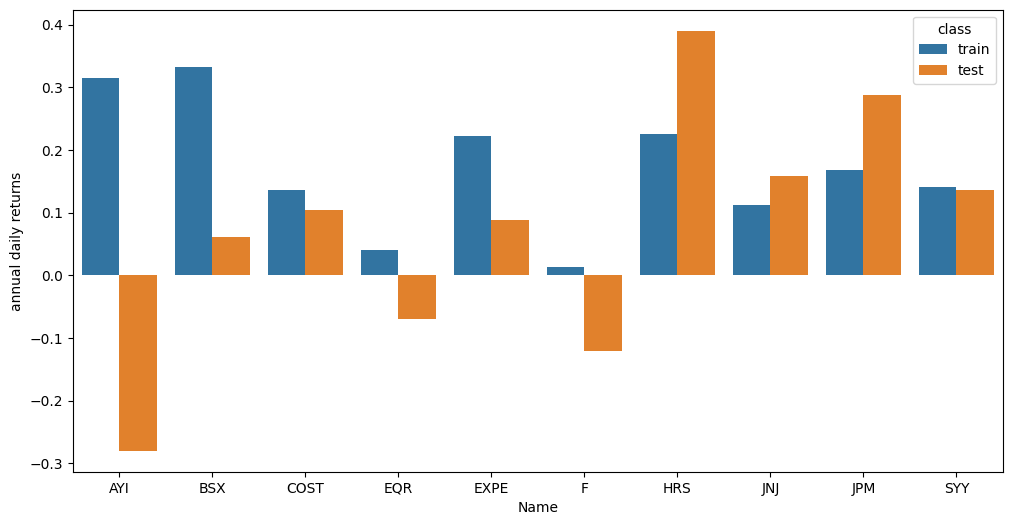

In [22]:
# Получаем годовые значения
pf20train_covann = pf20train_df.cov()*252
pf20test_covann = pf20test_df.cov()*252
pf20train_covann.max(axis=None)
pf20train_drann = pf20train_df.mean()*252
pf20test_drann = pf20test_df.mean()*252
pf20_drann = pf20train_drann.to_frame()
pf20_drann['class'] = 'train'
pf20_drann = pd.concat([pf20_drann, pf20test_drann]).fillna('test')
pf20_drann.columns = ['annual daily returns', 'class']
plt.figure(figsize=(12, 6))
sns.barplot(pf20_drann, x='Name', y='annual daily returns', hue='class')

Text(0.5, 0.95, 'Annualized covariance matrix for daily returns')

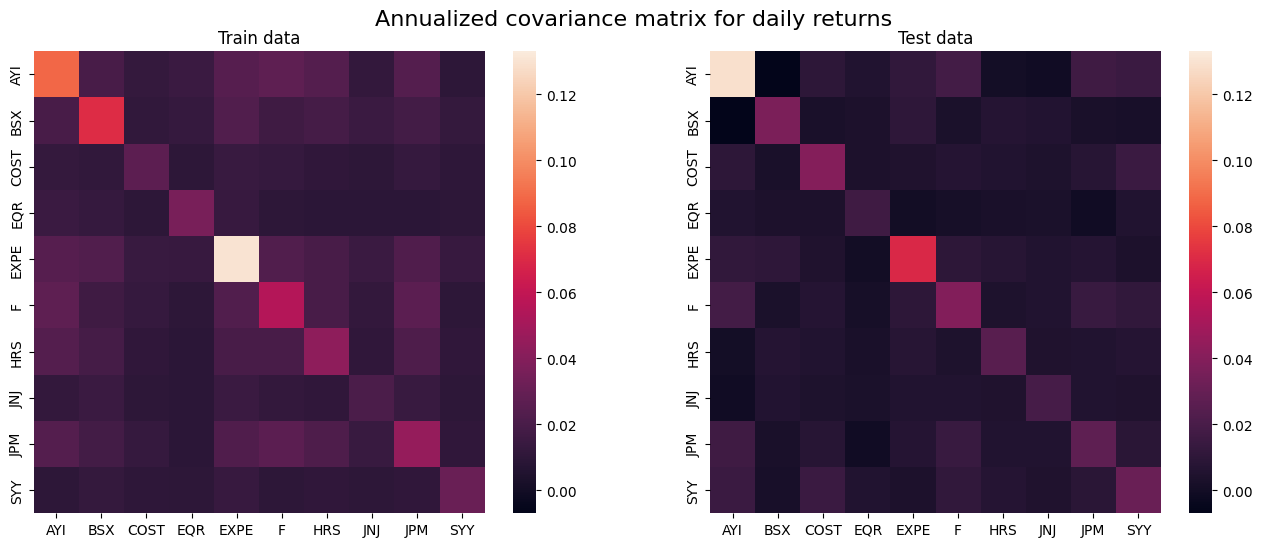

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
vmin = 0.975 * min(pf20train_covann.min(axis=None), pf20test_covann.min(axis=None))
vmax = 1.025 * max(pf20train_covann.max(axis=None), pf20test_covann.max(axis=None))
sns.heatmap(pf20train_covann, vmin=vmin, vmax=vmax, ax=ax[0]).set(xlabel=None, ylabel=None, title='Train data')
sns.heatmap(pf20test_covann, vmin=vmin, vmax=vmax, ax=ax[1]).set(xlabel=None, ylabel=None, title='Test data')
fig.suptitle('Annualized covariance matrix for daily returns', fontsize=16, y=0.95)

## Implementation

In [24]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import pennylane as qml
from pennylane import qaoa
import numpy as np
from scipy.optimize import minimize


def portfolio_optimisation_ex_qaoa(mu, sigma, budget, n_layers, n_iter, n_shots=4096, n_levels=2, simulator="lightning.qubit"):
    n_assets = len(mu)
    risk_factor = 0.5
    n_qubits = n_assets * n_levels
    dev = qml.device(simulator, wires=n_qubits)

    # Classical (exact) solution
    pf = PortfolioOptimization(mu, sigma, risk_factor, budget)
    qp = pf.to_quadratic_program()
    
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(qp)
    penalty_value = converter.penalty
    print(penalty_value)
    
    exact_mes = NumPyMinimumEigensolver()
    optimizer = MinimumEigenOptimizer(exact_mes)
    result_classic = optimizer.solve(qp)
    
    # QAOA solution
    ## Portfolio to Ising problem
    def portfolio_to_ising_coeffs(mu, sigma, budget, penalty_value, risk_factor):
        
        h = np.zeros(n_qubits)
        
        for i in range(n_assets):
            qubit_start = i * n_levels
            # Binary encoding: w_i = sum(2^k * b_{i,k})
            for k in range(n_levels):
                h[qubit_start + k] -= mu[i] * (2**k)
        
        J = np.zeros((n_qubits, n_qubits))
        
        for i in range(n_assets):
            for j in range(i, n_assets):
                if i == j:
                    continue
                else:
                    coeff = sigma[i, j]
                    for k1 in range(n_levels):
                        for k2 in range(n_levels):
                            q1 = i * n_levels + k1
                            q2 = j * n_levels + k2
                            J[q1, q2] += coeff * (2**(k1 + k2))
                            J[q2, q1] += coeff * (2**(k1 + k2))

        J = risk_factor * J

        for i in range(n_assets):
            for j in range(n_assets):
                w_i_scale = sum(2**k for k in range(n_levels))
                w_j_scale = sum(2**k for k in range(n_levels))
                
                for k1 in range(n_levels):
                    for k2 in range(n_levels):
                        q1 = i * n_levels + k1
                        q2 = j * n_levels + k2
                        J[q1, q2] += penalty_value * w_i_scale * w_j_scale
                        J[q2, q1] += penalty_value * w_i_scale * w_j_scale
                
                for k1 in range(n_levels):
                    q1 = i * n_levels + k1
                    h[q1] -= 2 * penalty_value * budget * (2**k1)
        
        return h, J

    # Construct PennyLane Hamiltonian from Ising coeffs
    def ising_to_hamiltonian(h, J):
        coeffs = []
        paulis = []
        
        for i, hi in enumerate(h):
            if abs(hi) > 1e-10:
                coeffs.append(hi)
                paulis.append(qml.PauliZ(i))
        
        for i in range(len(h)):
            for j in range(i+1, len(h)):
                if abs(J[i,j]) > 1e-10:
                    coeffs.append(J[i,j])
                    paulis.append(qml.PauliZ(i) @ qml.PauliZ(j))
        
        return qml.Hamiltonian(coeffs, paulis)
    
    h, J = portfolio_to_ising_coeffs(mu, sigma, budget, penalty_value, risk_factor)

    H_C = ising_to_hamiltonian(h, J)
    H_M = qml.Hamiltonian(np.ones(n_qubits), [qml.PauliX(i) for i in range(n_qubits)])

    ## Energy for minimization
    @qml.qnode(dev)
    def energy(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return qml.expval(H_C)

    results_qa_t = []
    def energy_x(*, intermediate_result):
        results_qa_t.append(intermediate_result)
        
    result_qa = minimize(energy, np.random.uniform(0, 2*np.pi, 2*n_layers), method='COBYLA', options={'maxiter': n_iter}, callback=energy_x)

    ## Sampling optimized circuit values
    @qml.qnode(dev, shots=n_shots)
    def sample_portfolio(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return qml.sample()

    qa_samples = sample_portfolio(result_qa.x)
    
    ## Expectation values of optimized model
    @qml.qnode(dev)
    def measure_all_z(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    qa_expect = measure_all_z(result_qa.x)

    return result_classic, result_qa, results_qa_t, qa_samples, qa_expect, penalty_value

In [25]:
'''
def decode_discretized(expectation_z):
        weights = []
        for asset in range(n_assets):
            start = asset * n_levels
            bits = np.where(expectation_z[start:start+n_qubits] < 0, 1, 0)
            weight = sum(b * (2**k) for k, b in enumerate(bits)) / (2**n_levels)
            weights.append(weight)
        return np.array(weights)
'''

'\ndef decode_discretized(expectation_z):\n        weights = []\n        for asset in range(n_assets):\n            start = asset * n_levels\n            bits = np.where(expectation_z[start:start+n_qubits] < 0, 1, 0)\n            weight = sum(b * (2**k) for k, b in enumerate(bits)) / (2**n_levels)\n            weights.append(weight)\n        return np.array(weights)\n'

In [26]:
#mu = pf20train_drann.to_numpy()
#sigma = pf20train_covann.to_numpy()

In [27]:
budget = [3, 4, 6,]
n_layers = [1, 2, 3,]
n_iter = [100, 200, 300,]
n_levels = [1, 2]
n_shots = [1024, 2048, 3072, 4096]

In [28]:
# example
#cc, qa, qa_t, qa_samples, qa_expect, pv = portfolio_optimisation_ex_qaoa(mu, sigma, budget=3, n_layers=2, n_iter=100, n_levels=2)

In [29]:
#cc.x, qa, qa_samples

In [30]:
#qa_samples = pd.DataFrame(qa_samples)
#qa, qa_samples.value_counts().head(), qa, qa_samples.value_counts().value_counts()

In [31]:
#qa_samples.value_counts().reset_index().loc[0].to_numpy()[:10] @ mu, cc.x @ mu

In [32]:
'''
cc_return = cc.x @ mu
qa_bin_return = qa_bin @ mu
qa_return = qa @ mu
cc_risk = np.sqrt(cc.x @ sigma @ cc.x)
qa_bin_risk = np.sqrt(qa_bin @ sigma @ qa_bin)
qa_risk = np.sqrt(qa @ sigma @ qa)
cc_sharpe = (cc_return - 0.045) / cc_risk
qa_bin_sharpe = (qa_bin_return - 0.045) / qa_bin_risk
qa_sharpe = (qa_return - 0.045) / qa_risk
cc_return, qa_bin_return, qa_return, cc_risk, qa_bin_risk, qa_risk, cc_sharpe, qa_bin_sharpe, qa_sharpe, sum(cc.x), sum(qa_bin), sum(qa)
'''

'\ncc_return = cc.x @ mu\nqa_bin_return = qa_bin @ mu\nqa_return = qa @ mu\ncc_risk = np.sqrt(cc.x @ sigma @ cc.x)\nqa_bin_risk = np.sqrt(qa_bin @ sigma @ qa_bin)\nqa_risk = np.sqrt(qa @ sigma @ qa)\ncc_sharpe = (cc_return - 0.045) / cc_risk\nqa_bin_sharpe = (qa_bin_return - 0.045) / qa_bin_risk\nqa_sharpe = (qa_return - 0.045) / qa_risk\ncc_return, qa_bin_return, qa_return, cc_risk, qa_bin_risk, qa_risk, cc_sharpe, qa_bin_sharpe, qa_sharpe, sum(cc.x), sum(qa_bin), sum(qa)\n'

In [33]:
#qa_return = qa @ mu
#qa_risk = np.sqrt(qa @ sigma @ qa)
#qa_sharpe = (qa_return - 0.045) / qa_risk
#cc_return, qa_return, cc_risk, qa_risk, cc_sharpe, qa_sharpe

In [34]:
#from scipy.spatial import distance

#distance.hamming(cc.x, qa_samples.value_counts().reset_index().loc[0].to_numpy()[:10])
#distance.hamming(cc.x, qa_bin)

In [35]:
# получить DF (mu, sigma) X budget X n_layers X n_iter

# QSVM vs SVM

## Dataset - "SME - Synthetic UK Businesses financial statistics"

### Описание

Информация о многих данных используемых в финансовом секторе недоступна рядовому пользователю. Финансовые организации, в погоне за прибылью, используют всю возможную информацию о своих клиентах, и редко ей делятся. Поэтому для исследований в таких областях как fraud detection или credit scoring часто используются синтетические данные, как в данном случае.

[Данный датасет](https://www.kaggle.com/datasets/nayaone/sme-uk-businesses-financial-statistics) содержит финансовую и базовую информацию о 1000 малых и средних предприятий Великобритании. В сумме он содержит более 200 аттрибутов, которые могут быть использованы для оценки выживаемости и успешности предприятий.

### Содержание

Датасеты, присутстующие в данном наборе:

    Account Receivable: Funds that customers owe your company for products or services that have been invoiced.
    Businesses: List of enterprises and their information
    Covid: Financial stats of the companies during the pandemic waves
    Credit Account History: History of a credit account and usage of
    Credit Card History: History of the credit card usage and debt amount of an enterprise
    Credit Rating: credit rating of listed businesses which is a quantified assessment of the creditworthiness of a borrower in general terms or with respect to a financial obligation.
    Director: UK Individual who is on the Director position in companies listed in Businesses
    Factoring: Financial transaction and a type of debtor finance in which a business sells its accounts receivable to a third party at a discount.
    Individual: UK Individuals information
    Loan: Information of the paid and unpaid Loans by the enterprise


In [36]:
import os
cds_dc = {f:pd.read_csv(os.path.join('./datasets/credit_scoring', f)) for f in os.listdir('./datasets/credit_scoring')}
cds_dc.keys()
#cds_ls[0].info()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [37]:
[(k, len(cds_dc[k])) for k in cds_dc.keys()]

[('Businesses.csv', 1000),
 ('Loan.csv', 90),
 ('Account_Receivable.csv', 79648),
 ('Individual.csv', 10000),
 ('Credit_Rating.csv', 900),
 ('Factoring.csv', 974),
 ('Director.csv', 2878),
 ('COVID.csv', 884),
 ('Credit_Card_History.csv', 353),
 ('Credit_Account_History.csv', 1509)]

In [38]:
cds_dc['Individual.csv'].info()
cds_dc['Individual.csv']['occupation']

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10000 non-null  int64  
 1   name                             10000 non-null  str    
 2   sex                              10000 non-null  str    
 3   date_of_birth                    10000 non-null  str    
 4   email_address                    10000 non-null  str    
 5   Unnamed: 5                       0 non-null      float64
 6   geography                        10000 non-null  str    
 7   postcode                         10000 non-null  str    
 8   ethnic_group                     10000 non-null  str    
 9   nationality                      10000 non-null  str    
 10  highest_level_of_qualifications  10000 non-null  str    
 11  employment_status                10000 non-null  str    
 12  industry                      

0                         2. Professional occupations
1                                               Other
2                                               Other
3                                               Other
4                                               Other
                            ...                      
9995    4. Administrative and secretarial occupations
9996        7. Sales and customer service occupations
9997                                            Other
9998                                            Other
9999                                            Other
Name: occupation, Length: 10000, dtype: str

In [39]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [40]:
cds_dc['Account_Receivable.csv'].info()
cds_dc['Credit_Rating.csv'].info()
cds_dc['Credit_Rating.csv'].head()

<class 'pandas.DataFrame'>
RangeIndex: 79648 entries, 0 to 79647
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           79648 non-null  int64  
 1   invoice_id           79648 non-null  int64  
 2   company_reg_number   79648 non-null  int64  
 3   invoice_date         79648 non-null  str    
 4   invoice_amount       79648 non-null  float64
 5   end_date             79648 non-null  str    
 6   disputed             79648 non-null  int64  
 7   paper_or_electronic  79648 non-null  str    
dtypes: float64(1), int64(4), str(3)
memory usage: 4.9 MB
<class 'pandas.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      900 non-null    int64  
 1   company_reg_num

,Unnamed: 0,company_reg_number,credit_report_agency,credit_report_date,credit_report_model,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness,liens_filed_and_open,liens_closed_last_five_years,missed_and_late_payments_last_five_years,filed_court_cases_last_five_years,payment_index,credit_report_negative_items,credit_report_good_standing_items,business_failure_score,credit_report_credit_score,ratio_debt_to_revenue
0,0,20000000,Experian,2021-11-23,FICO 8,6,7548.00,0,1,0,0,2,1,4,63,765,0.013964
1,1,20000001,Equifax,2021-01-29,FICO 8,5,28100.00,0,0,0,0,21,1,1,59,676,0.121491
2,2,20000002,Equifax,2021-04-13,FICO 8,6,15631.00,0,1,0,0,16,1,4,53,663,0.076898
3,3,20000003,Equifax,2021-09-25,FICO 4,3,0.00,0,0,0,0,2,0,3,93,0,0.000000
4,4,20000004,Equifax,2021-08-13,FICO 9,0,75605.28,0,0,0,0,17,0,4,81,773,0.193195


In [41]:
cds_dc['Factoring.csv'].head()
cds_dc['Factoring.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Unnamed: 0          974 non-null    int64
 1   company_reg_number  974 non-null    int64
 2   revenue_2019        974 non-null    int64
 3   factor_amount       974 non-null    int64
 4   factor_percent      974 non-null    int64
 5   factoring_type      105 non-null    str  
 6   factoring_provider  105 non-null    str  
dtypes: int64(5), str(2)
memory usage: 53.4 KB


In [42]:
cds_dc['Director.csv'].head()
cds_dc['Director.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   2878 non-null   int64  
 1   company_reg_number           2878 non-null   int64  
 2   indv_id                      2878 non-null   int64  
 3   officer                      2878 non-null   int64  
 4   ubo                          2878 non-null   int64  
 5   current_employee_at_company  2878 non-null   int64  
 6   employment_status            2878 non-null   int64  
 7   appointment                  2878 non-null   str    
 8   termination                  2878 non-null   str    
 9   disqual                      2878 non-null   int64  
 10  start_date_of_disqual        0 non-null      float64
 11  end_date_of_disqual          0 non-null      float64
 12  dob                          2878 non-null   str    
 13  active_company               

In [43]:
cds_dc['Businesses.csv'].head()
cds_dc['Businesses.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1000 non-null   int64  
 1   borough_county                1000 non-null   str    
 2   address                       1000 non-null   str    
 3   contact_phone_no              1000 non-null   str    
 4   primary_sector                1000 non-null   str    
 5   entity_trade_name             1000 non-null   str    
 6   company_type                  1000 non-null   str    
 7   entity_name                   1000 non-null   str    
 8   company_reg_number            1000 non-null   int64  
 9   annual_turnover               1000 non-null   str    
 10  number_of_employees           1000 non-null   str    
 11  number_of_officers            1000 non-null   int64  
 12  incorporation_date            1000 non-null   str    
 13  entity_status  

In [44]:
cds_dc['Credit_Card_History.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              353 non-null    int64  
 1   cc_number               353 non-null    int64  
 2   company_reg_number      353 non-null    int64  
 3   cc_start_date           353 non-null    str    
 4   cc_billing_enddate      353 non-null    str    
 5   cc_agreed_limit         353 non-null    float64
 6   cc_balance_limit_ratio  353 non-null    float64
 7   cc_missed_payments      78 non-null     float64
 8   missed_payments_number  353 non-null    int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 24.9 KB


In [45]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [46]:
cds_dc['Account_Receivable.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 79648 entries, 0 to 79647
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           79648 non-null  int64  
 1   invoice_id           79648 non-null  int64  
 2   company_reg_number   79648 non-null  int64  
 3   invoice_date         79648 non-null  str    
 4   invoice_amount       79648 non-null  float64
 5   end_date             79648 non-null  str    
 6   disputed             79648 non-null  int64  
 7   paper_or_electronic  79648 non-null  str    
dtypes: float64(1), int64(4), str(3)
memory usage: 4.9 MB


In [47]:
cds_dc['Account_Receivable.csv']['company_reg_number'].value_counts()

company_reg_number
20000550    349
20000962    348
20000870    345
20000382    344
20000505    344
           ... 
20000177     11
20000355     11
20000804     11
20000969     11
20000814     10
Name: count, Length: 957, dtype: int64

In [48]:
len(set(cds_dc['Businesses.csv']['company_reg_number']) & set(cds_dc['Loan.csv']['company_reg_number']))

87

In [49]:
cds_dc['Loan.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         90 non-null     int64  
 1   loan                                               90 non-null     int64  
 2   overdraft                                          90 non-null     int64  
 3   primary_sector                                     90 non-null     str    
 4   company_reg_number                                 90 non-null     int64  
 5   loan_id                                            90 non-null     str    
 6   loan_start_date                                    90 non-null     str    
 7   loan_original_amount                               90 non-null     int64  
 8   loan_status                                        90 non-null     str    
 9   loan_repayment_frequenc

In [50]:
cds_dc['Loan.csv']['company_reg_number'].value_counts()

company_reg_number
20000034    2
20000150    2
20000984    2
20000000    1
20000017    1
           ..
20000929    1
20000936    1
20000947    1
20000953    1
20000970    1
Name: count, Length: 87, dtype: int64

In [51]:
#cds_merged = cds_dc['Businesses.csv'].merge(cds_dc['Loan.csv'], on='company_reg_number', how='left', suffixes=('', '_LOAN')).\
#merge(cds_dc['Account_Receivable.csv'], on='company_reg_number', how='left', suffixes=('', '_ACC_RECV')).\
#merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
#merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
#merge(cds_dc['Credit_Card_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CREDIT_CARD')).\
#merge(cds_dc['Credit_Account_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CREDIT_ACC'))
#cds_merged.info(max_cols=500)

In [52]:
#cds_merged.dropna(axis=1, how='all', inplace=True)
#cds_merged.info(max_cols=500)
#cds_merged.drop(columns=['Unnamed: 0', 'Unnamed: 0_LOAN',  'Unnamed: 0_ACC_RECV', 'Unnamed: 0_CR',
#                         'Unnamed: 0_FACTORING', 'Unnamed: 0_CREDIT_CARD', 'Unnamed: 0_CREDIT_ACC'], inplace=True)
#cds_merged.info(max_cols=500)

In [53]:
#set(cds_dc['Businesses.csv'].columns) - set(cds_dc['Credit_Account_History.csv'].columns) 

In [54]:
cds_dc['Credit_Account_History.csv'].info()
cds_dc['Credit_Account_History.csv']['company_reg_number'].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1509 non-null   int64  
 1   borough_county                1509 non-null   str    
 2   address                       1509 non-null   str    
 3   contact_phone_no              1509 non-null   str    
 4   primary_sector                1509 non-null   str    
 5   entity_trade_name             1509 non-null   str    
 6   company_type                  1509 non-null   str    
 7   entity_name                   1509 non-null   str    
 8   company_reg_number            1509 non-null   int64  
 9   annual_turnover               1509 non-null   str    
 10  number_of_employees           1509 non-null   str    
 11  number_of_officers            1509 non-null   int64  
 12  incorporation_date            1509 non-null   str    
 13  entity_status 

company_reg_number
20000015    4
20000049    4
20000067    4
20000097    4
20000100    4
           ..
20000993    1
20000995    1
20000996    1
20000997    1
20000999    1
Name: count, Length: 1000, dtype: int64

In [55]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [56]:
#cds_merged = cds_dc['Credit_Account_History.csv'].\
#merge(cds_dc['Loan.csv'], on='company_reg_number', how='left', suffixes=('', '_LOAN')).\
#merge(cds_dc['Account_Receivable.csv'], on='company_reg_number', how='left', suffixes=('', '_ACC_RECV')).\
#merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
#merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
#merge(cds_dc['Credit_Card_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CREDIT_CARD')).\
#merge(cds_dc['COVID.csv'], on='company_reg_number', how='left', suffixes=('', '_COVID')).\
#merge(cds_dc['Director.csv'], on='company_reg_n20000015umber', how='left', suffixes=('', '_DIRECTOR'))
#cds_merged.dropna(axis=1, how='all', inplace=True)
#cds_merged.drop(columns=['Unnamed: 0', 'Unnamed: 0_LOAN', 'Unnamed: 0_ACC_RECV', 'Unnamed: 0_CR',
#                         'Unnamed: 0_FACTORING', 'Unnamed: 0_CREDIT_CARD', 'Unnamed: 0_COVID', 'Unnamed: 0_DIRECTOR'], inplace=True)

In [57]:
#cds_merged.info(250)

In [58]:
#cds_merged[['primary_sector', 'primary_sector_LOAN', 'revenue_2019', 'revenue_2019_FACTORING']]
#cds_merged.loc[cds_merged['revenue_2019'] != cds_merged['revenue_2019_FACTORING'], ['revenue_2019', 'revenue_2019_FACTORING']].isna().all()
#cds_merged.drop(columns=['revenue_2019_FACTORING'], inplace=True)
#cds_merged.info()

In [59]:
#cds_merged['primary_sector_LOAN'].equals(cds_merged['primary_sector'])

In [60]:
#cds_merged['revenue_2019_FACTORING'].equals(cds_merged['revenue_2019'])

In [61]:
#cds_merged = cds_merged.drop(columns=['revenue_2019_FACTORING'])

In [62]:
#cds_merged.info(max_cols=250, verbose=True)

In [63]:
#cds_merged.loc[~cds_merged['primary_sector_LOAN'].eq(cds_merged['primary_sector']), ['company_reg_number', 'primary_sector', 'primary_sector_LOAN']]

In [64]:
#cds_merged.loc[~cds_merged['primary_sector_LOAN'].eq(cds_merged['primary_sector']), ['company_reg_number', 'primary_sector', 'primary_sector_LOAN']]['primary_sector_LOAN'].isna().all()

In [65]:
#cds_merged['primary_sector_LOAN'].value_counts()

In [66]:
#cds_dc['Loan.csv'].info()

In [67]:
#cds_merged = cds_merged.drop(columns=['primary_sector_LOAN'])

In [68]:
#cds_dc['Loan.csv']['company_reg_number'].isin(cds_dc['Credit_Account_History.csv']['company_reg_number']).all()

In [69]:
#cds_merged.nunique()
#cds_merged.value_counts()

In [70]:
#cds_dc['COVID.csv'].info(max_cols=150, verbose=True)
#cds_dc['COVID.csv'].nunique()

In [71]:
#cds_merged.info(max_cols=250, verbose=True)

In [72]:
#cds_merged['revenue_2019'].equals(cds_merged['2019_revenue'])

In [73]:
#cds_merged = cds_merged.drop(columns=['2019_revenue'])

In [74]:
#cds_merged[['current_account_number', 'current_account_numbers']].value_counts()

In [75]:
#cds_merged[['current_account_numbers_list', 'current_account_numbers']].value_counts()

In [76]:
#cds_merged[['current_account_numbers_list', 'current_account_number']].value_counts()

In [77]:
#cds_merged = cds_merged.drop(columns=['current_account_numbers', 'current_account_numbers_list'])

In [78]:
#cds_merged['ca_start_date'].value_counts()

In [79]:
#cds_merged['turnover_bands'].value_counts()

In [80]:
#cds_merged.info(max_cols=250, verbose=True)

In [81]:
cds_dc['Credit_Account_History.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1509 non-null   int64  
 1   borough_county                1509 non-null   str    
 2   address                       1509 non-null   str    
 3   contact_phone_no              1509 non-null   str    
 4   primary_sector                1509 non-null   str    
 5   entity_trade_name             1509 non-null   str    
 6   company_type                  1509 non-null   str    
 7   entity_name                   1509 non-null   str    
 8   company_reg_number            1509 non-null   int64  
 9   annual_turnover               1509 non-null   str    
 10  number_of_employees           1509 non-null   str    
 11  number_of_officers            1509 non-null   int64  
 12  incorporation_date            1509 non-null   str    
 13  entity_status 

In [82]:
cds_dc['Loan.csv'].info(), cds_dc['Credit_Card_History.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         90 non-null     int64  
 1   loan                                               90 non-null     int64  
 2   overdraft                                          90 non-null     int64  
 3   primary_sector                                     90 non-null     str    
 4   company_reg_number                                 90 non-null     int64  
 5   loan_id                                            90 non-null     str    
 6   loan_start_date                                    90 non-null     str    
 7   loan_original_amount                               90 non-null     int64  
 8   loan_status                                        90 non-null     str    
 9   loan_repayment_frequenc

(None, None)

In [83]:
cds_dc['Loan.csv']['company_reg_number'].nunique(), cds_dc['Credit_Card_History.csv']['company_reg_number'].nunique()

(87, 120)

In [84]:
cds_dc['Loan.csv']['company_reg_number'].isin(cds_dc['Credit_Card_History.csv']['company_reg_number']).value_counts()

company_reg_number
False    90
Name: count, dtype: int64

In [85]:
cds_dc['Credit_Rating.csv'].info()
cds_dc['Credit_Rating.csv'].head()

<class 'pandas.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      900 non-null    int64  
 1   company_reg_number                              900 non-null    int64  
 2   credit_report_agency                            900 non-null    str    
 3   credit_report_date                              900 non-null    str    
 4   credit_report_model                             900 non-null    str    
 5   credit_report_requests_to_view_last_five_years  900 non-null    int64  
 6   credit_report_total_indebtedness                900 non-null    float64
 7   liens_filed_and_open                            900 non-null    int64  
 8   liens_closed_last_five_years                    900 non-null    int64  
 9   missed_and_late_payments_last_five_years        900 no

,Unnamed: 0,company_reg_number,credit_report_agency,credit_report_date,credit_report_model,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness,liens_filed_and_open,liens_closed_last_five_years,missed_and_late_payments_last_five_years,filed_court_cases_last_five_years,payment_index,credit_report_negative_items,credit_report_good_standing_items,business_failure_score,credit_report_credit_score,ratio_debt_to_revenue
0,0,20000000,Experian,2021-11-23,FICO 8,6,7548.00,0,1,0,0,2,1,4,63,765,0.013964
1,1,20000001,Equifax,2021-01-29,FICO 8,5,28100.00,0,0,0,0,21,1,1,59,676,0.121491
2,2,20000002,Equifax,2021-04-13,FICO 8,6,15631.00,0,1,0,0,16,1,4,53,663,0.076898
3,3,20000003,Equifax,2021-09-25,FICO 4,3,0.00,0,0,0,0,2,0,3,93,0,0.000000
4,4,20000004,Equifax,2021-08-13,FICO 9,0,75605.28,0,0,0,0,17,0,4,81,773,0.193195


In [86]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [87]:
#cds_dc['Businesses.csv'].info()
#cds_dc['Credit_Account_History.csv'].info()
set(cds_dc['Businesses.csv'].columns) - set(cds_dc['Credit_Account_History.csv'].columns)

{'Unnamed: 37',
 'Unnamed: 38',
 'Unnamed: 39',
 'Unnamed: 40',
 'Unnamed: 41',
 'Unnamed: 42',
 'Unnamed: 43',
 'Unnamed: 44',
 'Unnamed: 45'}

In [88]:
#cds_dc['COVID.csv'].info(max_cols=250, verbose=True)

In [89]:
#cds_merged = cds_dc['Loan.csv'].\
#merge(cds_dc['Credit_Card_History.csv'], on='company_reg_number', how='outer', suffixes=('_LOAN', '_CC')).\
#merge(cds_dc['Credit_Account_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CA')).\
#merge(cds_dc['Director.csv'], on='company_reg_number', how='left', suffixes=('', '_DIRECTOR')).\
#merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
#merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
#merge(cds_dc['Account_Receivable.csv'], on='company_reg_number', how='left', suffixes=('', '_RECIAVABLE'))
#merge(cds_dc['COVID.csv'], on='company_reg_number', how='left', suffixes=('', '_COVID'))
#cds_merged.drop(columns=['Unnamed: 0_LOAN', 'Unnamed: 0_CC'], inplace=True)
#cds_merged.info(max_cols=250, verbose=True)

In [90]:
ca_df = cds_dc['Credit_Account_History.csv'].copy()
ca_df.drop(columns=['Unnamed: 0', '2019_revenue', 'current_account_numbers', 'current_account_numbers_list',
                    'date_of_name_change', 'previous_name'], inplace=True)
#ca_df.drop_duplicates()
ca_df['company_reg_number'].value_counts()
ca_df[ca_df['company_reg_number'] == 20000015]

,borough_county,address,contact_phone_no,primary_sector,entity_trade_name,company_type,entity_name,company_reg_number,annual_turnover,number_of_employees,...,number_of_accounts,current_acc_fraction,total_amount,ca_start_date,current_account_number,amount,rev_ratio,cost_ratio,pay_in_amount,pay_out_amount
17,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-06-24,6800913902220,6.968133e+05,0.501145,0.498855,3.492042e+05,3.476092e+05
18,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-09-24,5952047126497,4.699177e+06,0.501145,0.498855,2.354967e+06,2.344210e+06
19,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-09-24,4349694393169,-5.182651e+06,0.501145,0.498855,-2.597257e+06,-2.585394e+06
20,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-05-24,1662208407185,1.918856e+06,0.501145,0.498855,9.616241e+05,9.572318e+05


In [91]:
# Изучаем кредитную историю
loans_df = cds_dc['Loan.csv'].copy()
loans_df = loans_df.convert_dtypes()
loans_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Unnamed: 0                                         90 non-null     Int64 
 1   loan                                               90 non-null     Int64 
 2   overdraft                                          90 non-null     Int64 
 3   primary_sector                                     90 non-null     string
 4   company_reg_number                                 90 non-null     Int64 
 5   loan_id                                            90 non-null     string
 6   loan_start_date                                    90 non-null     string
 7   loan_original_amount                               90 non-null     Int64 
 8   loan_status                                        90 non-null     string
 9   loan_repayment_frequency          

In [92]:
loans_df['loan_id'].unique().all(), loans_df['interest'].median()

(np.True_, np.float64(8.0))

In [93]:
loans_df = loans_df.drop(columns=['loan_id', 'Unnamed: 0'])
loans_df = loans_df.drop(loans_df[loans_df['loan_status'].isin(['Disbursing', 'Available'])].index)
loans_df = loans_df.fillna(value={'early_repayment_allowed': 1})
loans_df.info()

<class 'pandas.DataFrame'>
Index: 72 entries, 0 to 89
Data columns (total 17 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   loan                                               72 non-null     Int64 
 1   overdraft                                          72 non-null     Int64 
 2   primary_sector                                     72 non-null     string
 3   company_reg_number                                 72 non-null     Int64 
 4   loan_start_date                                    72 non-null     string
 5   loan_original_amount                               72 non-null     Int64 
 6   loan_status                                        72 non-null     string
 7   loan_repayment_frequency                           72 non-null     string
 8   loan_date_due_to_close                             72 non-null     string
 9   loan_amount_outstanding_including_futur

In [94]:
loans_df['company_reg_number'].value_counts()
loans_df[loans_df['company_reg_number'] == 20000984]

,loan,overdraft,primary_sector,company_reg_number,loan_start_date,loan_original_amount,loan_status,loan_repayment_frequency,loan_date_due_to_close,loan_amount_outstanding_including_future_interest,interest,loan_number_of_missed_payments,loan_default_date,loan_satisfaction_date,early_repayment_allowed,fixed_interest,total_time_payments_late
88,0,1,49-53 : Transport & Storage (inc. postal),20000984,2021-06-03,32450,Repaid,Monthly,2022-06-03,0,<NA>,0,<NA>,2021-06-27 00:00:00,1,0,0
89,1,0,49-53 : Transport & Storage (inc. postal),20000984,2020-02-20,24650,Defaulted,Monthly,2023-02-20,0,<NA>,3,2020-09-09 00:00:00,<NA>,1,1,42


In [95]:
loans_df = loans_df.drop(88)
cds_dc['Loan.csv']['loan_amount_outstanding_including_future_interest'].value_counts()
loans_df['interest'].value_counts()
loans_df = loans_df.drop(columns=['loan_default_date', 'loan_satisfaction_date', 'loan_amount_outstanding_including_future_interest', 'interest'])

In [96]:
loans_df.info()

<class 'pandas.DataFrame'>
Index: 71 entries, 0 to 89
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   loan                            71 non-null     Int64 
 1   overdraft                       71 non-null     Int64 
 2   primary_sector                  71 non-null     string
 3   company_reg_number              71 non-null     Int64 
 4   loan_start_date                 71 non-null     string
 5   loan_original_amount            71 non-null     Int64 
 6   loan_status                     71 non-null     string
 7   loan_repayment_frequency        71 non-null     string
 8   loan_date_due_to_close          71 non-null     string
 9   loan_number_of_missed_payments  71 non-null     Int64 
 10  early_repayment_allowed         71 non-null     Int64 
 11  fixed_interest                  71 non-null     Int64 
 12  total_time_payments_late        71 non-null     Int64 
dtypes: Int64

In [97]:
loans_df.describe()

,loan,overdraft,company_reg_number,loan_original_amount,loan_number_of_missed_payments,early_repayment_allowed,fixed_interest,total_time_payments_late
count,71.0,71.0,71.0,71.0,71.0,71.0,71.0,71.0
mean,0.239437,0.760563,20000460.366197,73963.380282,0.267606,0.943662,0.15493,3.056338
std,0.429777,0.429777,280.873497,99675.068869,0.735969,0.232214,0.364413,8.897652
min,0.0,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,1.0,20000225.5,21450.0,0.0,1.0,0.0,0.0
50%,0.0,1.0,20000417.0,33700.0,0.0,1.0,0.0,0.0
75%,0.0,1.0,20000669.0,94100.0,0.0,1.0,0.0,0.0
max,1.0,1.0,20000984.0,510850.0,3.0,1.0,1.0,42.0


In [98]:
# Выделяем кредитные данные, критичные для разделения по классам
loans_cs_df = loans_df[['company_reg_number', 'loan_status', 'loan_number_of_missed_payments']]
loans_cs_df.info()

<class 'pandas.DataFrame'>
Index: 71 entries, 0 to 89
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   company_reg_number              71 non-null     Int64 
 1   loan_status                     71 non-null     string
 2   loan_number_of_missed_payments  71 non-null     Int64 
dtypes: Int64(2), string(1)
memory usage: 2.4 KB


In [99]:
# Изучаем историю по кредитным картам
cc_df = cds_dc['Credit_Card_History.csv'].copy()
cc_df.head(), cc_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              353 non-null    int64  
 1   cc_number               353 non-null    int64  
 2   company_reg_number      353 non-null    int64  
 3   cc_start_date           353 non-null    str    
 4   cc_billing_enddate      353 non-null    str    
 5   cc_agreed_limit         353 non-null    float64
 6   cc_balance_limit_ratio  353 non-null    float64
 7   cc_missed_payments      78 non-null     float64
 8   missed_payments_number  353 non-null    int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 24.9 KB


(   Unnamed: 0     cc_number  company_reg_number               cc_start_date  \
 0         707  158384600849            20000707  2014-12-15 13:48:09.345360   
 1         707  858434036314            20000707  2012-11-09 13:48:09.345360   
 2         707  156497216184            20000707  2011-05-01 13:48:09.345360   
 3         817  663270282405            20000817  2017-12-11 13:48:09.564507   
 4         419  502471524674            20000419  2016-04-19 13:48:10.372319   
 
   cc_billing_enddate  cc_agreed_limit  cc_balance_limit_ratio  \
 0              01-18     30921.687609                  20.256   
 1              12-14     30921.687609                  21.784   
 2              06-12     23191.265707                  17.439   
 3              01-20      8303.637079                   8.000   
 4              05-29     10177.017600                  11.482   
 
    cc_missed_payments  missed_payments_number  
 0                 NaN                       0  
 1                 NaN

In [100]:
cc_df[~cc_df['cc_missed_payments'].fillna(0).eq(cc_df['missed_payments_number'])]

,Unnamed: 0,cc_number,company_reg_number,cc_start_date,cc_billing_enddate,cc_agreed_limit,cc_balance_limit_ratio,cc_missed_payments,missed_payments_number
12,811,151896780211,20000811,2015-09-11 13:48:15.394532,10-14,20056.462053,20.173,NaN,1
13,746,202314873945,20000746,2021-01-26 13:48:15.470301,03-07,12196.449242,7.413,-7.0,0
16,751,568492519197,20000751,2014-12-27 13:48:15.633218,02-01,40075.331979,22.676,NaN,1
20,649,629598809081,20000649,2020-09-30 13:48:16.596347,11-12,19488.797700,8.428,NaN,1
24,448,749955698701,20000448,2020-01-08 13:48:17.085422,02-13,16347.491408,7.415,-3.0,1
...,...,...,...,...,...,...,...,...,...
340,946,820765382232,20000946,2019-02-23 13:49:55.101121,04-01,1736.598341,9.541,NaN,1
343,616,397447058753,20000616,2019-12-06 13:49:55.795376,01-17,2443.192570,9.457,NaN,1
346,616,519703415183,20000616,2019-01-15 13:49:56.492055,02-28,1832.394428,7.272,NaN,1
350,626,763844729854,20000626,2018-01-03 13:49:57.410359,02-14,4899.695041,7.493,NaN,1


In [101]:
cc_df['missed_payments_number'].value_counts().sort_index()
#cc_df['cc_missed_payments'].value_counts()

missed_payments_number
0     169
1     129
2       2
3       5
4       3
5       5
6      10
7       7
8       5
9       9
10      3
11      3
12      1
13      2
Name: count, dtype: int64

In [102]:
min(cc_df['cc_start_date']), max(cc_df['cc_start_date'])

('2008-11-18 13:49:30.691685', '2021-09-06 13:49:14.441170')

In [103]:
cc_df = cc_df.convert_dtypes()
cc_df['cc_start_date'] = pd.to_datetime(cc_df['cc_start_date'])
cc_df = cc_df[cc_df['cc_start_date'] > (max(cc_df['cc_start_date']) - pd.DateOffset(years=5))]
cc_df.info()

<class 'pandas.DataFrame'>
Index: 170 entries, 3 to 352
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              170 non-null    Int64         
 1   cc_number               170 non-null    Int64         
 2   company_reg_number      170 non-null    Int64         
 3   cc_start_date           170 non-null    datetime64[us]
 4   cc_billing_enddate      170 non-null    string        
 5   cc_agreed_limit         170 non-null    Float64       
 6   cc_balance_limit_ratio  170 non-null    Float64       
 7   cc_missed_payments      39 non-null     Int64         
 8   missed_payments_number  170 non-null    Int64         
dtypes: Float64(2), Int64(5), datetime64[us](1), string(1)
memory usage: 14.4 KB


In [104]:
cc_df['company_reg_number'].value_counts()
cc_df['missed_payments_number_total'] = cc_df.groupby('company_reg_number')['missed_payments_number'].transform('sum')
cc_df.head()

,Unnamed: 0,cc_number,company_reg_number,cc_start_date,cc_billing_enddate,cc_agreed_limit,cc_balance_limit_ratio,cc_missed_payments,missed_payments_number,missed_payments_number_total
3,817,663270282405,20000817,2017-12-11 13:48:09.564507,01-20,8303.637079,8.0,3,3,3
7,118,999054584500,20000118,2019-12-30 13:48:12.740480,02-03,13565.210218,11.166,<NA>,0,0
8,118,657072131353,20000118,2020-03-17 13:48:12.817858,04-21,13565.210218,8.955,<NA>,0,0
9,196,371016881727,20000196,2018-08-30 13:48:13.599192,10-08,17429.865975,10.45,<NA>,0,0
10,813,180665640502,20000813,2016-12-20 13:48:14.816201,01-28,37856.624365,7.984,<NA>,0,0


In [105]:
# Выделяем данные по кредитным картам, критичные для разделения по классам
cc_cs_df = cc_df[['company_reg_number', 'missed_payments_number_total']].drop_duplicates()
cc_cs_df.info()

<class 'pandas.DataFrame'>
Index: 64 entries, 3 to 350
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   company_reg_number            64 non-null     Int64
 1   missed_payments_number_total  64 non-null     Int64
dtypes: Int64(2)
memory usage: 1.6 KB


In [106]:
# Объединяем данные по кредитам и по кредитным картам, критичные для разделения по классам
cs_df = loans_cs_df.merge(cc_cs_df, on='company_reg_number', how='outer')

In [107]:
cs_df['loan_number_of_missed_payments'].value_counts()

loan_number_of_missed_payments
0    61
1     4
2     3
3     3
Name: count, dtype: Int64

In [108]:
# Формируем классы для сэмплов
cs_df['potential_defaulter'] = cs_df['loan_number_of_missed_payments'] > 0
cs_df['defaulter'] = cs_df['loan_status'] == 'Default'
cs_df['cc_potential_defaulter'] = cs_df['missed_payments_number_total'] > 0
cs_df['cc_defaulter'] = cs_df['missed_payments_number_total'] >= 5
cs_df.drop(columns=['loan_status', 'loan_number_of_missed_payments', 'missed_payments_number_total'], inplace=True)
cs_df.fillna(False, inplace=True)
cs_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_reg_number      135 non-null    Int64  
 1   potential_defaulter     135 non-null    boolean
 2   defaulter               135 non-null    boolean
 3   cc_potential_defaulter  135 non-null    boolean
 4   cc_defaulter            135 non-null    boolean
dtypes: Int64(1), boolean(4)
memory usage: 2.4 KB


In [109]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [110]:
#cs_df.merge(cds_dc['Businesses.csv'], on='company_reg_number', how='left')
#cds_dc['Account_Receivable.csv'].value_counts()

In [111]:
#cds_dc['Director.csv'][cds_dc['Director.csv']['termination'] == 'Present'].describe()#['indv_id'].value_counts()
#cds_dc['Director.csv'][cds_dc['Director.csv']['termination'] == 'Present']
cds_dc['Director.csv'].describe()
#cds_dc['Director.csv']['indv_id'].nunique()
#cds_dc['Director.csv']['termination'].value_counts()

,Unnamed: 0,company_reg_number,indv_id,officer,ubo,current_employee_at_company,employment_status,disqual,start_date_of_disqual,end_date_of_disqual,active_company
count,2878.000000,2.878000e+03,2878.000000,2878.000000,2878.000000,2878.000000,2878.0,2878.0,0.0,0.0,2878.0
mean,1438.500000,2.000050e+07,4752.602502,0.480195,0.539611,0.711258,1.0,0.0,NaN,NaN,1.0
std,830.951362,2.905341e+02,2775.789937,0.499694,0.498515,0.453257,0.0,0.0,NaN,NaN,0.0
min,0.000000,2.000000e+07,0.000000,0.000000,0.000000,0.000000,1.0,0.0,NaN,NaN,1.0
25%,719.250000,2.000025e+07,2223.000000,0.000000,0.000000,0.000000,1.0,0.0,NaN,NaN,1.0
50%,1438.500000,2.000050e+07,4741.500000,0.000000,1.000000,1.000000,1.0,0.0,NaN,NaN,1.0
75%,2157.750000,2.000075e+07,7016.750000,1.000000,1.000000,1.000000,1.0,0.0,NaN,NaN,1.0
max,2877.000000,2.000100e+07,9934.000000,1.000000,1.000000,1.000000,1.0,0.0,NaN,NaN,1.0


In [112]:
dr_df = cds_dc['Director.csv'].drop(columns=['employment_status', 'disqual', 'start_date_of_disqual', 'end_date_of_disqual', 'active_company'])
dr_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Unnamed: 0                   2878 non-null   int64
 1   company_reg_number           2878 non-null   int64
 2   indv_id                      2878 non-null   int64
 3   officer                      2878 non-null   int64
 4   ubo                          2878 non-null   int64
 5   current_employee_at_company  2878 non-null   int64
 6   appointment                  2878 non-null   str  
 7   termination                  2878 non-null   str  
 8   dob                          2878 non-null   str  
 9   incorp_date                  2878 non-null   str  
dtypes: int64(6), str(4)
memory usage: 225.0 KB


In [113]:
dr_df[['indv_id', 'officer', 'ubo']].value_counts().sort_index()
dr_df.loc[dr_df['termination'] == 'Present', ['company_reg_number', 'officer', 'ubo']].value_counts().sort_index().value_counts()

count
1    1688
2     137
3      13
5       4
6       3
4       2
Name: count, dtype: int64

In [114]:
# Объединяем данные по классам с характеристиками классов
cs2_df = cs_df.\
merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
merge(dr_df, on='company_reg_number', how='left', suffixes=('', '_DIRECTOR')).\
merge(cds_dc['COVID.csv'], on='company_reg_number', how='left', suffixes=('', '_COVID')).\
merge(cds_dc['Credit_Account_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CA'))
cs2_df.info(max_cols=250, verbose=True)

<class 'pandas.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 200 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              743 non-null    Int64  
 1    potential_defaulter                             743 non-null    boolean
 2    defaulter                                       743 non-null    boolean
 3    cc_potential_defaulter                          743 non-null    boolean
 4    cc_defaulter                                    743 non-null    boolean
 5    Unnamed: 0                                      725 non-null    float64
 6    credit_report_agency                            725 non-null    str    
 7    credit_report_date                              725 non-null    str    
 8    credit_report_model                             725 non-null    str    
 9    credit_report_requests_to_view_last_five_

In [115]:
cs2_df.drop(columns=['Unnamed: 0', 'Unnamed: 0_FACTORING', 'Unnamed: 0_DIRECTOR', 'Unnamed: 0_COVID', 'Unnamed: 0_CA',
                    '2019_revenue', 'revenue_2019_CA', 'date_of_name_change', 'previous_name'], inplace=True)
cs2_df.info(max_cols=250, verbose=True)

<class 'pandas.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 191 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              743 non-null    Int64  
 1    potential_defaulter                             743 non-null    boolean
 2    defaulter                                       743 non-null    boolean
 3    cc_potential_defaulter                          743 non-null    boolean
 4    cc_defaulter                                    743 non-null    boolean
 5    credit_report_agency                            725 non-null    str    
 6    credit_report_date                              725 non-null    str    
 7    credit_report_model                             725 non-null    str    
 8    credit_report_requests_to_view_last_five_years  725 non-null    float64
 9    credit_report_total_indebtedness         

In [116]:
cs2_df.loc[cs2_df['credit_report_agency'].isna(), cs2_df.columns[5:20]].isna().all()

credit_report_agency                              True
credit_report_date                                True
credit_report_model                               True
credit_report_requests_to_view_last_five_years    True
credit_report_total_indebtedness                  True
liens_filed_and_open                              True
liens_closed_last_five_years                      True
missed_and_late_payments_last_five_years          True
filed_court_cases_last_five_years                 True
payment_index                                     True
credit_report_negative_items                      True
credit_report_good_standing_items                 True
business_failure_score                            True
credit_report_credit_score                        True
ratio_debt_to_revenue                             True
dtype: bool

In [117]:
cs2_df = cs2_df.dropna(subset='credit_report_agency')
cs2_df.info(max_cols=250, verbose=True)

<class 'pandas.DataFrame'>
Index: 725 entries, 0 to 742
Data columns (total 191 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              725 non-null    Int64  
 1    potential_defaulter                             725 non-null    boolean
 2    defaulter                                       725 non-null    boolean
 3    cc_potential_defaulter                          725 non-null    boolean
 4    cc_defaulter                                    725 non-null    boolean
 5    credit_report_agency                            725 non-null    str    
 6    credit_report_date                              725 non-null    str    
 7    credit_report_model                             725 non-null    str    
 8    credit_report_requests_to_view_last_five_years  725 non-null    float64
 9    credit_report_total_indebtedness              

In [118]:
cs2_df[['revenue_2019', 'factor_amount', 'factor_percent']].describe()
cs2_df[['factor_percent']].value_counts()

factor_percent
0.0               659
90.0               33
47.0               12
38.0                8
6.0                 2
46.0                2
28.0                1
Name: count, dtype: int64

In [119]:
cs2_df['factoring_type'].value_counts()

factoring_type
Whole_turnover_recourse        28
Selective_recourse             25
Whole_turnover_non_recourse     5
Name: count, dtype: int64

In [120]:
cs2_df.fillna(value={'revenue_2019': 0.0, 'factor_amount': 0.0, 'factor_percent': 0.0}, inplace=True)
cs2_df.info(max_cols=250, verbose=True)

<class 'pandas.DataFrame'>
Index: 725 entries, 0 to 742
Data columns (total 191 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              725 non-null    Int64  
 1    potential_defaulter                             725 non-null    boolean
 2    defaulter                                       725 non-null    boolean
 3    cc_potential_defaulter                          725 non-null    boolean
 4    cc_defaulter                                    725 non-null    boolean
 5    credit_report_agency                            725 non-null    str    
 6    credit_report_date                              725 non-null    str    
 7    credit_report_model                             725 non-null    str    
 8    credit_report_requests_to_view_last_five_years  725 non-null    float64
 9    credit_report_total_indebtedness              

In [121]:
cs2_df.loc[:, cs2_df.columns[115:132]].describe()

,turnover_wave03,turnover_wave04,turnover_wave05,turnover_wave06,turnover_wave07,turnover_wave08,turnover_wave09,turnover_wave10,turnover_wave11,turnover_wave12,turnover_wave13,turnover_wave14,turnover_vs_operating_cost_wave10,turnover_vs_operating_cost_wave11,turnover_vs_operating_cost_wave12,turnover_vs_operating_cost_wave13,turnover_vs_operating_cost_wave14
count,594.000000,573.000000,517.000000,602.000000,569.000000,660.000000,677.000000,704.000000,717.000000,708.000000,703.000000,718.000000,704.000000,717.000000,708.000000,703.000000,718.000000
mean,-33.739057,-16.109948,-12.918762,-20.963455,-15.456942,-13.698485,-16.299852,-15.028409,-16.052999,-6.487288,-6.150782,1.199164,7.808239,-5.145049,-0.709040,-0.240398,-8.940111
std,34.686030,26.659537,24.938785,31.520988,28.335428,22.765780,29.465609,28.178294,27.981837,15.267297,24.525178,16.454770,31.447740,19.096525,15.619868,16.453179,24.508286
min,-97.000000,-86.000000,-86.000000,-89.000000,-88.000000,-79.000000,-98.000000,-87.000000,-83.000000,-87.000000,-85.000000,-90.000000,-83.000000,-82.000000,-81.000000,-80.000000,-87.000000
25%,-70.000000,-34.000000,-13.000000,-42.000000,-33.000000,-29.000000,-14.000000,-14.000000,-13.000000,-7.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000
50%,-33.000000,0.000000,0.000000,-8.000000,-9.000000,-8.000000,0.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,7.000000,7.000000,0.000000
max,35.000000,37.000000,42.000000,79.000000,73.000000,73.000000,35.000000,82.000000,40.000000,40.000000,78.000000,35.000000,82.000000,20.000000,16.000000,17.000000,19.000000


In [122]:
cs2_df.loc[:, cs2_df.columns[115:132]] = \
cs2_df.loc[:, cs2_df.columns[115:132]].fillna(cs2_df.loc[:, cs2_df.columns[115:132]].describe().loc['50%',:])
cs2_df.loc[:, cs2_df.columns[115:132]].info()

<class 'pandas.DataFrame'>
Index: 725 entries, 0 to 742
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   turnover_wave03                    725 non-null    float64
 1   turnover_wave04                    725 non-null    float64
 2   turnover_wave05                    725 non-null    float64
 3   turnover_wave06                    725 non-null    float64
 4   turnover_wave07                    725 non-null    float64
 5   turnover_wave08                    725 non-null    float64
 6   turnover_wave09                    725 non-null    float64
 7   turnover_wave10                    725 non-null    float64
 8   turnover_wave11                    725 non-null    float64
 9   turnover_wave12                    725 non-null    float64
 10  turnover_wave13                    725 non-null    float64
 11  turnover_wave14                    725 non-null    float64
 12  turnover_v

In [123]:
cs2_df[cs2_df.columns[166:179]].describe()

,capex,cogs,cogs_plus_capex,costs,accounts_receivable,capital_and_reserves,current_assets,current_liabilities,fixed_assets,long_term_liabilities,provisions_for_liabilities
count,717.000000,7.170000e+02,7.170000e+02,7.170000e+02,717.000000,7.170000e+02,7.170000e+02,7.170000e+02,7.170000e+02,7.170000e+02,717.000000
mean,1365.608647,1.347162e+05,1.360818e+05,1.044655e+06,42868.921897,1.466676e+05,3.535627e+05,2.968834e+05,1.631547e+05,7.316605e+04,56312.790795
std,2584.197465,5.227175e+05,5.226159e+05,1.108677e+06,39594.325477,2.853982e+05,3.483007e+05,2.958067e+05,4.178878e+05,1.741042e+05,62755.436015
min,0.000000,2.019350e+03,2.083360e+03,3.053452e+04,2631.000000,-3.788100e+04,1.662000e+04,1.280700e+04,1.138000e+03,-3.787900e+04,1921.000000
25%,58.300000,5.412650e+03,5.581520e+03,3.275576e+05,13972.000000,2.073600e+04,1.003020e+05,7.244500e+04,1.589900e+04,6.514000e+03,12463.000000
50%,191.450000,1.573735e+04,1.699004e+04,9.348580e+05,37676.000000,6.295300e+04,2.732230e+05,1.494060e+05,3.636400e+04,2.541300e+04,28651.000000
75%,851.810000,1.062851e+05,1.101771e+05,1.311468e+06,52989.000000,1.153140e+05,4.400490e+05,4.683910e+05,9.714900e+04,6.594300e+04,67937.000000
max,9162.790000,4.839787e+06,4.839787e+06,8.123174e+06,187894.000000,1.474311e+06,1.680807e+06,1.168898e+06,2.398869e+06,1.038280e+06,233779.000000


In [124]:
cs2_df.loc[cs2_df['capex'].isna(), cs2_df.columns[166:179]].isna().all()

capex                         True
cogs                          True
cogs_plus_capex               True
costs                         True
turnover_bands                True
accounts_receivable           True
capital_and_reserves          True
current_assets                True
current_liabilities           True
filing_date                   True
fixed_assets                  True
long_term_liabilities         True
provisions_for_liabilities    True
dtype: bool

In [125]:
cs2_df.dropna(subset='capex', inplace=True)
cs2_df.info(max_cols=250, verbose=True)

<class 'pandas.DataFrame'>
Index: 717 entries, 0 to 742
Data columns (total 191 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              717 non-null    Int64  
 1    potential_defaulter                             717 non-null    boolean
 2    defaulter                                       717 non-null    boolean
 3    cc_potential_defaulter                          717 non-null    boolean
 4    cc_defaulter                                    717 non-null    boolean
 5    credit_report_agency                            717 non-null    str    
 6    credit_report_date                              717 non-null    str    
 7    credit_report_model                             717 non-null    str    
 8    credit_report_requests_to_view_last_five_years  717 non-null    float64
 9    credit_report_total_indebtedness              

In [126]:
# Переходим к feature selection
cs3_df = cs2_df.convert_dtypes()

In [127]:
cs3_df.info(max_cols=250, verbose=True)

<class 'pandas.DataFrame'>
Index: 717 entries, 0 to 742
Data columns (total 191 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              717 non-null    Int64  
 1    potential_defaulter                             717 non-null    boolean
 2    defaulter                                       717 non-null    boolean
 3    cc_potential_defaulter                          717 non-null    boolean
 4    cc_defaulter                                    717 non-null    boolean
 5    credit_report_agency                            717 non-null    string 
 6    credit_report_date                              717 non-null    string 
 7    credit_report_model                             717 non-null    string 
 8    credit_report_requests_to_view_last_five_years  717 non-null    Int64  
 9    credit_report_total_indebtedness              

In [128]:
cs3_df[cs3_df.columns[5:8]].value_counts()

credit_report_agency  credit_report_date  credit_report_model
Equifax               2021-01-05          FICO 8                 35
                      2021-11-01          FICO 8                 32
TransUnion            2021-03-18          FICO 8                 28
                      2021-05-08          FICO 8                 24
Equifax               2021-07-30          FICO 8                 24
                                                                 ..
TransUnion            2021-03-14          FICO 8                  1
                      2021-07-10          FICO 8                  1
                      2021-01-27          FICO 8                  1
                      2021-06-04          FICO 8                  1
Experian              2021-05-03          FICO 4                  1
Name: count, Length: 126, dtype: int64

In [129]:
cs3_df[cs3_df.columns[7]].value_counts(), cs3_df[cs3_df.columns[6]].value_counts()

(credit_report_model
 FICO 8          365
 FICO 5          108
 VantageScore     78
 FICO 4           63
 FICO 9           57
 FICO 2           46
 Name: count, dtype: Int64,
 credit_report_date
 2021-01-05    35
 2021-11-01    32
 2021-03-18    28
 2021-05-08    24
 2021-07-30    24
               ..
 2021-09-02     1
 2021-03-14     1
 2021-07-10     1
 2021-01-27     1
 2021-06-04     1
 Name: count, Length: 110, dtype: Int64)

In [130]:
import datetime as dt
cs3_df[cs3_df.columns[6]] = pd.to_datetime(cs3_df[cs3_df.columns[6]]).apply(lambda x: dt.datetime.toordinal(x))
# 5, 7 to ohc, na-ignore (one-hot-encoder)

In [131]:
cs3_df[cs3_df.columns[23:25]].apply(pd.Series.value_counts)
# 23, 24 to ohc, na-ignore

,factoring_type,factoring_provider
ABN AMRO Commercial Finance,<NA>,1
AIB Commercial Finance,<NA>,1
Bibby Financial Services Ltd,<NA>,14
GapCap,<NA>,5
HSBC Invoice Finance (UK) Ltd,<NA>,4
Hitachi Capital UK,<NA>,1
Market Invoice,<NA>,8
NatWest Group plc,<NA>,2
Optimum Finance,<NA>,12
Selective_recourse,25,<NA>


In [132]:
cs3_df[cs3_df.columns[29:45]].head()

,appointment,termination,dob,incorp_date,trading_status_wave03,trading_status_wave04,trading_status_wave05,trading_status_wave06,trading_status_wave07,trading_status_wave08,trading_status_wave09,trading_status_wave10,trading_status_wave11,trading_status_wave12,trading_status_wave13,trading_status_wave14
0,2016-08-29,Present,1958-06-15,2012-10-21,Currently trading,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
1,2017-06-24,Present,1960-06-07,2012-10-21,Currently trading,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
2,2019-03-25,Present,1984-11-22,2017-01-05,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
3,2017-01-05,2020-09-05 00:00:00,1969-05-28,2017-01-05,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
4,2014-11-02,Present,1970-07-14,2014-11-02,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading


In [133]:
cs3_df[cs3_df.columns[29:33]].apply(pd.Series.value_counts)

,appointment,termination,dob,incorp_date
1900-06-04,<NA>,<NA>,<NA>,10
1947-11-05,<NA>,<NA>,<NA>,2
1957-01-27,<NA>,<NA>,3,<NA>
1957-06-09,<NA>,<NA>,4,<NA>
1957-08-09,<NA>,<NA>,3,<NA>
...,...,...,...,...
2024-04-23 00:00:00,<NA>,2,<NA>,<NA>
2058-07-07 00:00:00,<NA>,1,<NA>,<NA>
2059-05-01 00:00:00,<NA>,2,<NA>,<NA>
2110-01-02 00:00:00,<NA>,2,<NA>,<NA>


In [134]:
cs3_df[cs3_df.columns[30]] = cs3_df[cs3_df.columns[30]].replace('Present', pd.NA)
for i in range(29, 33):
    cs3_df[cs3_df.columns[i]] = pd.to_datetime(cs3_df[cs3_df.columns[i]]).apply(lambda x: dt.datetime.toordinal(x))
cs3_df.loc[cs3_df[cs3_df.columns[30]] == 1, cs3_df.columns[30]] = max(cs3_df[cs3_df.columns[30]]) + 365
cs3_df[cs3_df.columns[29:33]].describe()

,appointment,termination,dob,incorp_date
count,717.000000,717.000000,717.000000,717.000000
mean,735476.580195,761782.379358,720904.775453,733966.556485
std,2343.073060,15031.684470,4209.994077,5769.151601
min,722745.000000,725840.000000,714441.000000,693750.000000
25%,735143.000000,738927.000000,716927.000000,734491.000000
50%,736057.000000,770663.000000,720514.000000,735406.000000
75%,736781.000000,770663.000000,724357.000000,736069.000000
max,738132.000000,770663.000000,730064.000000,737441.000000


In [135]:
cs3_df[cs3_df.columns[33:45]].apply(pd.Series.value_counts)
# 33:45 to orc (ordinal encoder)

,trading_status_wave03,trading_status_wave04,trading_status_wave05,trading_status_wave06,trading_status_wave07,trading_status_wave08,trading_status_wave09,trading_status_wave10,trading_status_wave11,trading_status_wave12,trading_status_wave13,trading_status_wave14
Currently trading,586,565,509,594,561,652,677,696,709,700,695,710
Has permanently ceased trading **,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,2,2
Has temporarily closed or temporarily paused trading,131,152,208,123,156,65,40,21,8,15,20,5


In [136]:
cs3_df[cs3_df.columns[57:115]].head()

,online_challenge_wave13,footfall_wave11,footfall_wave12,footfall_wave13,prices_bought_wave03,prices_bought_wave04,prices_bought_wave05,prices_bought_wave06,prices_bought_wave07,prices_bought_wave08,...,importing_effect_wave13,importing_effect_wave14,stock_levels_wave07,stock_levels_wave08,stock_levels_wave09,stock_levels_wave10,stock_levels_wave11,stock_levels_wave12,stock_levels_wave13,stock_levels_wave14
0,Other,Not sure,Footfall has stayed the same,Footfall has decreased,Prices did not change any more than normal,Prices did not change any more than normal,<NA>,Prices did not change any more than normal,Prices increased more than normal,Prices did not change any more than normal,...,Importing has not been affected,Importing has not been affected,Stock levels have not changed,Not sure,Stock levels are lower than normal,Stock levels have not changed,Stock levels are lower than normal,Not sure,Stock levels have not changed,Stock levels have not changed
1,Other,Not sure,Footfall has stayed the same,Footfall has decreased,Prices did not change any more than normal,Prices did not change any more than normal,<NA>,Prices did not change any more than normal,Prices increased more than normal,Prices did not change any more than normal,...,Importing has not been affected,Importing has not been affected,Stock levels have not changed,Not sure,Stock levels are lower than normal,Stock levels have not changed,Stock levels are lower than normal,Not sure,Stock levels have not changed,Stock levels have not changed
2,Other,Not applicable,Not applicable,Not applicable,Prices did not change any more than normal,<NA>,Prices did not change any more than normal,Prices did not change any more than normal,Prices increased more than normal,Prices did not change any more than normal,...,Importing has not been affected,Not sure,Not sure,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Not sure,Stock levels are lower than normal
3,Other,Not applicable,Not applicable,Not applicable,Prices did not change any more than normal,<NA>,Prices did not change any more than normal,Prices did not change any more than normal,Prices increased more than normal,Prices did not change any more than normal,...,Importing has not been affected,Not sure,Not sure,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Not sure,Stock levels are lower than normal
4,Did not experience any challenges selling good...,Not applicable,Not applicable,Not applicable,Not sure,Prices did not change any more than normal,"Some prices increased, some prices decreased",Prices did not change any more than normal,Prices did not change any more than normal,Not sure,...,"Importing, but less than normal","Importing, but less than normal",Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels have not changed,Stock levels are higher than normal,Stock levels have not changed,Stock levels have not changed


In [137]:
#cs3_df[cs3_df.columns[57]].value_counts()
cs3_df[cs3_df.columns[58:115]].apply(pd.Series.value_counts)
cs3_df[cs3_df.columns[58:115]] = cs3_df[cs3_df.columns[58:115]].replace(['Not sure', 'Not applicable'], pd.NA)
# 57 to ohc, na-ignore
# 58:115 to orc

In [138]:
cs3_df[cs3_df.columns[132:147]].apply(pd.Series.value_counts)
cs3_df[cs3_df.columns[132:147]] = cs3_df[cs3_df.columns[132:147]].replace(['Not sure', 'Not applicable'], pd.NA)
# 132:147 to orc

In [139]:
cs3_df[cs3_df.columns[148:155]].apply(pd.Series.value_counts)
# 148:155 to ohc (+ preprocessing i.e. BoW ?)
# 155 to orc

,borough_county,address,contact_phone_no,primary_sector,entity_trade_name,company_type,entity_name
(0003) 8394057,<NA>,<NA>,4,<NA>,<NA>,<NA>,<NA>
(0133) 1061853,<NA>,<NA>,8,<NA>,<NA>,<NA>,<NA>
(0159) 4268175,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>
(0171) 2755670,<NA>,<NA>,32,<NA>,<NA>,<NA>,<NA>
(0234) 2806538,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
Wolverhampton,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
Worcester,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
Wrexham,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
"Wright-Moore, Ward, Reynolds, Austin, Patel and Harrison",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20


In [140]:
cs3_df[cs3_df.columns[158]] = pd.to_datetime(cs3_df[cs3_df.columns[158]]).apply(lambda x: dt.datetime.toordinal(x))

In [141]:
cs3_df[cs3_df.columns[160:165]].apply(pd.Series.value_counts)

,dissolved_on,officers_and_percent_owned,ubo_and_percent_owned,country_of_incorporation,country_of_primary_operation
2001-01-13,5,<NA>,<NA>,<NA>,<NA>
2001-05-01,3,<NA>,<NA>,<NA>,<NA>
2002-10-19,2,<NA>,<NA>,<NA>,<NA>
2003-03-15,6,<NA>,<NA>,<NA>,<NA>
2010-07-24,8,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...
"[[9787, 25], [4371, 75]]",<NA>,<NA>,6,<NA>,<NA>
"[[9787, 25]]",<NA>,6,<NA>,<NA>,<NA>
"[[9794, 25], [3813, 75]]",<NA>,<NA>,8,<NA>,<NA>
"[[9794, 25], [6755, 75]]",<NA>,<NA>,2,<NA>,<NA>


In [142]:
cs3_df[cs3_df.columns[160]] = pd.to_datetime(cs3_df[cs3_df.columns[160]]).apply(lambda x: dt.datetime.toordinal(x))
cs3_df.drop(columns=['country_of_incorporation', 'country_of_primary_operation'], inplace=True)
cs3_df.info(max_cols=250, verbose=True)
# 161, 162 - ? check crossing data with Director.csv !

<class 'pandas.DataFrame'>
Index: 717 entries, 0 to 742
Data columns (total 189 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              717 non-null    Int64  
 1    potential_defaulter                             717 non-null    boolean
 2    defaulter                                       717 non-null    boolean
 3    cc_potential_defaulter                          717 non-null    boolean
 4    cc_defaulter                                    717 non-null    boolean
 5    credit_report_agency                            717 non-null    string 
 6    credit_report_date                              717 non-null    int64  
 7    credit_report_model                             717 non-null    string 
 8    credit_report_requests_to_view_last_five_years  717 non-null    Int64  
 9    credit_report_total_indebtedness              

In [143]:
cs3_df[cs3_df.columns[168]].value_counts()
# 168 - to orc

turnover_bands
1M-10.2M    404
0-632k      252
632k-1M      61
Name: count, dtype: Int64

In [144]:
cs3_df[cs3_df.columns[173]].value_counts()

filing_date
2021-05-02    56
2021-05-26    42
2021-05-21    38
2021-05-16    36
2021-05-04    36
              ..
2021-09-27     1
2021-05-08     1
2021-02-21     1
2021-11-27     1
2021-04-22     1
Name: count, Length: 70, dtype: Int64

In [145]:
cs3_df[cs3_df.columns[173]] = pd.to_datetime(cs3_df[cs3_df.columns[173]]).apply(lambda x: dt.datetime.toordinal(x))

In [146]:
cs3_df[cs3_df.columns[180:183]].apply(pd.Series.value_counts)
#cs3_df[cs3_df.columns[132:147]] = cs3_df[cs3_df.columns[132:147]].replace(['Not sure', 'Not applicable'], pd.NA)
cs3_df[cs3_df.columns[182]] = pd.to_datetime(cs3_df[cs3_df.columns[182]]).apply(lambda x: dt.datetime.toordinal(x))
# 180 - extract to several numeric features
# 181 - convert to numeric features (MB PRE-MERGE!)

In [147]:
# Данные с подготовленным планом для энкодинга + несколько возможных переработок
# 5, 7, 23, 24, 57, 148:155 - to ohc, na-ignore
# 33:45, 58:115, 132:147, 155, 168  - to orc
# 148:155 (some of), 161, 162, 180, 181 - transform?
# combine prices_waves, effect_waves?
cs4_df = cs3_df.reset_index()
cs4_df.info(max_cols=200, verbose=True)

<class 'pandas.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 190 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    index                                           717 non-null    int64  
 1    company_reg_number                              717 non-null    Int64  
 2    potential_defaulter                             717 non-null    boolean
 3    defaulter                                       717 non-null    boolean
 4    cc_potential_defaulter                          717 non-null    boolean
 5    cc_defaulter                                    717 non-null    boolean
 6    credit_report_agency                            717 non-null    string 
 7    credit_report_date                              717 non-null    int64  
 8    credit_report_model                             717 non-null    string 
 9    credit_report_requests_to_view_last_five_

In [148]:
cs4_df[cs4_df.columns[181]].value_counts(), cs4_df[cs4_df.columns[182]].value_counts()

(current_account_numbers
 {8482844310438: 10054463.915350493, 5067354835614: -14574004.25676663, 8591365683466: 27739603.386719085, 6401831718493: -21621371.515428737}     32
 {5817748456571: 210348.9644157782, 7455131018226: -555142.5042105974, 9806119516896: 2008323.113384683, 3790040152690: 16905.994784818413}        32
 {9995887597850: 867639.114447134, 1928382049523: 849217.4206114516, 3110993255107: -457349.37816448306, 9899715893242: -43321.87634958733}        28
 {6672281605259: 1234251.2379405298, 4074587103140: -701456.1485261223, 1203410646834: 897394.0876578401}                                          24
 {2940275564248: -1336161.9803568583, 1923632440328: 19637891.076000746, 3035103684662: 2778677.1199404188, 2378544302610: -16218828.177620579}    24
                                                                                                                                                   ..
 {3480634144313: 180583.33091026967}                                       

In [149]:
cs4_df.sort_values(by='company_reg_number', ascending=False)[cs4_df.columns[178:186]].sort_values(by='number_of_accounts', ascending=False).head(10)

,number_of_accounts,current_acc_fraction,total_amount,current_account_numbers,current_account_numbers_list,ca_start_date,current_account_number,amount
288,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{9209583932821: 8357352.399159724},736656,9209583932821,8357352.39916
289,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{4861655585134: 3339188.9540231028},736656,4861655585134,3339188.954023
291,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{3661332734249: -989149.8650655552},736564,3661332734249,-989149.865066
295,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{3661332734249: -989149.8650655552},736564,3661332734249,-989149.865066
294,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{6700235075090: -2162301.0857492713},736472,6700235075090,-2162301.085749
290,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{6700235075090: -2162301.0857492713},736472,6700235075090,-2162301.085749
292,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{9209583932821: 8357352.399159724},736656,9209583932821,8357352.39916
293,4,0.801,10668027.968,"{9209583932821: 8357352.399159724, 48616555851...",{4861655585134: 3339188.9540231028},736656,4861655585134,3339188.954023
357,4,0.62,7841254.899941,"{2940275564248: -1336161.9803568583, 192363244...",{3035103684662: 2778677.1199404188},736284,3035103684662,2778677.11994
685,4,0.592,2054367.027947,"{9995887597850: 867639.114447134, 192838204952...",{9899715893242: -43321.87634958733},734766,9899715893242,-43321.87635


In [150]:
cs4_df['number_of_accounts'].value_counts()

number_of_accounts
4    284
1    257
3    120
2     56
Name: count, dtype: Int64

In [151]:
cs4_df.groupby('company_reg_number')['current_acc_fraction'].apply(lambda x: (x.iloc[0] == x).all()).all()
cs4_df.groupby('company_reg_number')['total_amount'].apply(lambda x: (x.iloc[0] == x).all()).all()

np.True_

In [152]:
cs4_df = cs4_df.drop(columns=['current_account_numbers',	'current_account_numbers_list'])
cs4_df.sort_values(by='company_reg_number', ascending=False)[cs4_df.columns[178:184]].sort_values(by='number_of_accounts', ascending=False).head(10)

,number_of_accounts,current_acc_fraction,total_amount,ca_start_date,current_account_number,amount
288,4,0.801,10668027.968,736656,9209583932821,8357352.39916
289,4,0.801,10668027.968,736656,4861655585134,3339188.954023
291,4,0.801,10668027.968,736564,3661332734249,-989149.865066
295,4,0.801,10668027.968,736564,3661332734249,-989149.865066
294,4,0.801,10668027.968,736472,6700235075090,-2162301.085749
290,4,0.801,10668027.968,736472,6700235075090,-2162301.085749
292,4,0.801,10668027.968,736656,9209583932821,8357352.39916
293,4,0.801,10668027.968,736656,4861655585134,3339188.954023
357,4,0.62,7841254.899941,736284,3035103684662,2778677.11994
685,4,0.592,2054367.027947,734766,9899715893242,-43321.87635


In [153]:
cs4_df.groupby('company_reg_number')['ca_start_date'].agg('count')#rank(method='first')

company_reg_number
20000000     2
20000004     2
20000007     4
20000013     3
20000016     2
            ..
20000977    28
20000984     2
20000990     2
20000994     6
20000999     5
Name: ca_start_date, Length: 129, dtype: int64

In [154]:
cs4_df.loc[cs4_df['company_reg_number'] == 20000977, cs4_df.columns[178:184]]

,number_of_accounts,current_acc_fraction,total_amount,ca_start_date,current_account_number,amount
674,4,0.592,2054367.027947,734796,9995887597850,867639.114447
675,4,0.592,2054367.027947,734553,1928382049523,849217.420611
676,4,0.592,2054367.027947,734796,3110993255107,-457349.378164
677,4,0.592,2054367.027947,734766,9899715893242,-43321.87635
678,4,0.592,2054367.027947,734796,9995887597850,867639.114447
679,4,0.592,2054367.027947,734553,1928382049523,849217.420611
680,4,0.592,2054367.027947,734796,3110993255107,-457349.378164
681,4,0.592,2054367.027947,734766,9899715893242,-43321.87635
682,4,0.592,2054367.027947,734796,9995887597850,867639.114447
683,4,0.592,2054367.027947,734553,1928382049523,849217.420611


In [155]:
max(cs4_df.groupby('company_reg_number')['current_account_number'].agg('nunique'))#rank(method='first')

4

In [156]:
cds_dc.keys()
csac_df = cds_dc['Credit_Account_History.csv']

In [157]:
csac_df.columns
csac_df = csac_df.drop(columns=['Unnamed: 0', '2019_revenue', 'country_of_incorporation', 'country_of_primary_operation',
                                'current_account_numbers', 'current_account_numbers_list', 'date_of_name_change', 'previous_name'])

In [158]:
csac_df['ca_start_date'] = pd.to_datetime(csac_df['ca_start_date']).apply(lambda x: dt.datetime.toordinal(x))
csac_df['filing_date'] = pd.to_datetime(csac_df['filing_date']).apply(lambda x: dt.datetime.toordinal(x))
csac_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   borough_county              1509 non-null   str    
 1   address                     1509 non-null   str    
 2   contact_phone_no            1509 non-null   str    
 3   primary_sector              1509 non-null   str    
 4   entity_trade_name           1509 non-null   str    
 5   company_type                1509 non-null   str    
 6   entity_name                 1509 non-null   str    
 7   company_reg_number          1509 non-null   int64  
 8   annual_turnover             1509 non-null   str    
 9   number_of_employees         1509 non-null   str    
 10  number_of_officers          1509 non-null   int64  
 11  incorporation_date          1509 non-null   str    
 12  entity_status               1509 non-null   int64  
 13  dissolved_on                1509 non-null   

In [159]:
csac_df.sort_values(by=['number_of_accounts', 'company_reg_number'], ascending=False)[csac_df.columns[22:]].head(10)
#csac_df[csac_df.columns[25]].value_counts().size
#csac_df[csac_df.columns[22:31]].apply(pd.Series.value_counts)

,accounts_receivable,capital_and_reserves,current_assets,current_liabilities,filing_date,fixed_assets,long_term_liabilities,provisions_for_liabilities,revenue_2019,number_of_accounts,current_acc_fraction,total_amount,ca_start_date,current_account_number,amount,rev_ratio,cost_ratio,pay_in_amount,pay_out_amount
1481,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,733063,8655854196704,-2.637655e+05,0.509851,0.490149,-1.344811e+05,-1.292844e+05
1482,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,732788,6924082316308,8.359753e+05,0.509851,0.490149,4.262228e+05,4.097525e+05
1483,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,732788,8328031801333,3.877688e+06,0.509851,0.490149,1.977043e+06,1.900645e+06
1484,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,733032,2648262931767,-2.784863e+06,0.509851,0.490149,-1.419865e+06,-1.364998e+06
1475,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734796,9995887597850,8.676391e+05,0.544941,0.455059,4.728122e+05,3.948269e+05
1476,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734553,1928382049523,8.492174e+05,0.544941,0.455059,4.627735e+05,3.864440e+05
1477,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734796,3110993255107,-4.573494e+05,0.544941,0.455059,-2.492285e+05,-2.081209e+05
1478,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734766,9899715893242,-4.332188e+04,0.544941,0.455059,-2.360787e+04,-1.971401e+04
1440,51940.0,129081.0,273223.0,117341.0,737911,34114.0,60913.0,15254.0,1263939.0,4,0.683,2.516498e+06,736331,2431881601177,6.910136e+05,0.502261,0.497739,3.470692e+05,3.439444e+05
1441,51940.0,129081.0,273223.0,117341.0,737911,34114.0,60913.0,15254.0,1263939.0,4,0.683,2.516498e+06,736543,7939434632720,4.213154e+05,0.502261,0.497739,2.116103e+05,2.097051e+05


In [160]:
csac_df[['current_account_number', 'rev_ratio']].value_counts().value_counts()#sort_values()
#csac_df['current_account_number'].value_counts()

count
1    1421
Name: count, dtype: int64

In [161]:
# TODO: pivot 'ca_start_date', 'current_account_number', 'amount', 'pay_in_amount', 'pay_out_amount'

In [162]:
csac_df['timerank'] = csac_df.sort_values('ca_start_date', ascending=False).groupby('company_reg_number')['ca_start_date'].rank(method='first').astype(int)#transform(lambda x: x.sort_values())

In [163]:
csac_df.sort_values(by=['number_of_accounts', 'company_reg_number'], ascending=False)[csac_df.columns[22:]].head(10)

,accounts_receivable,capital_and_reserves,current_assets,current_liabilities,filing_date,fixed_assets,long_term_liabilities,provisions_for_liabilities,revenue_2019,number_of_accounts,current_acc_fraction,total_amount,ca_start_date,current_account_number,amount,rev_ratio,cost_ratio,pay_in_amount,pay_out_amount,timerank
1481,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,733063,8655854196704,-2.637655e+05,0.509851,0.490149,-1.344811e+05,-1.292844e+05,4
1482,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,732788,6924082316308,8.359753e+05,0.509851,0.490149,4.262228e+05,4.097525e+05,2
1483,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,732788,8328031801333,3.877688e+06,0.509851,0.490149,1.977043e+06,1.900645e+06,1
1484,52163.0,144129.0,308229.0,168602.0,737923,92130.0,87627.0,38778.0,1119946.0,4,0.758,2.196615e+06,733032,2648262931767,-2.784863e+06,0.509851,0.490149,-1.419865e+06,-1.364998e+06,3
1475,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734796,9995887597850,8.676391e+05,0.544941,0.455059,4.728122e+05,3.948269e+05,4
1476,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734553,1928382049523,8.492174e+05,0.544941,0.455059,4.627735e+05,3.864440e+05,1
1477,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734796,3110993255107,-4.573494e+05,0.544941,0.455059,-2.492285e+05,-2.081209e+05,3
1478,30671.0,26062.0,440049.0,424611.0,737931,36689.0,26064.0,67937.0,1119509.0,4,0.592,2.054367e+06,734766,9899715893242,-4.332188e+04,0.544941,0.455059,-2.360787e+04,-1.971401e+04,2
1440,51940.0,129081.0,273223.0,117341.0,737911,34114.0,60913.0,15254.0,1263939.0,4,0.683,2.516498e+06,736331,2431881601177,6.910136e+05,0.502261,0.497739,3.470692e+05,3.439444e+05,1
1441,51940.0,129081.0,273223.0,117341.0,737911,34114.0,60913.0,15254.0,1263939.0,4,0.683,2.516498e+06,736543,7939434632720,4.213154e+05,0.502261,0.497739,2.116103e+05,2.097051e+05,3


In [164]:
tst = csac_df.pivot(index='company_reg_number', columns='timerank', values=['ca_start_date', 'current_account_number', 'amount', 'pay_in_amount', 'pay_out_amount'])

In [165]:
#tst.columns, tst.columns.set_levels([f'{a}_{b}' for a, b in tst.columns.to_list()], level=1)#.droplevel(0)#apply(lambda x: x.join())
#[(a, f'{a}_{b}') for a, b in tst.columns.to_list()]
tst.columns, pd.MultiIndex.from_tuples([(a, f'{a}_{b}') for a, b in tst.columns.to_list()]).droplevel(0)
tst2 = tst.copy()
tst2.columns = pd.MultiIndex.from_tuples([(a, f'{a}_{b}') for a, b in tst.columns.to_list()]).droplevel(0)
tst2.reset_index()

,company_reg_number,ca_start_date_1,ca_start_date_2,ca_start_date_3,ca_start_date_4,current_account_number_1,current_account_number_2,current_account_number_3,current_account_number_4,amount_1,...,amount_3,amount_4,pay_in_amount_1,pay_in_amount_2,pay_in_amount_3,pay_in_amount_4,pay_out_amount_1,pay_out_amount_2,pay_out_amount_3,pay_out_amount_4
0,20000000,734948.0,NaN,NaN,NaN,3.376786e+12,NaN,NaN,NaN,8.696872e+05,...,NaN,NaN,438374.696000,NaN,NaN,NaN,431312.533728,NaN,NaN,NaN
1,20000001,731055.0,NaN,NaN,NaN,4.384592e+12,NaN,NaN,NaN,3.537734e+05,...,NaN,NaN,181101.636000,NaN,NaN,NaN,172671.727664,NaN,NaN,NaN
2,20000002,732674.0,NaN,NaN,NaN,8.705193e+12,NaN,NaN,NaN,3.352206e+05,...,NaN,NaN,169933.720000,NaN,NaN,NaN,165286.913776,NaN,NaN,NaN
3,20000003,736714.0,NaN,NaN,NaN,2.074759e+12,NaN,NaN,NaN,2.062191e+05,...,NaN,NaN,106795.806000,NaN,NaN,NaN,99423.261139,NaN,NaN,NaN
4,20000004,736603.0,NaN,NaN,NaN,1.099188e+12,NaN,NaN,NaN,3.694107e+05,...,NaN,NaN,186669.657000,NaN,NaN,NaN,182741.076968,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20000995,736035.0,NaN,NaN,NaN,5.539193e+12,NaN,NaN,NaN,4.720075e+05,...,NaN,NaN,240109.140000,NaN,NaN,NaN,231898.379738,NaN,NaN,NaN
996,20000996,736767.0,NaN,NaN,NaN,9.549242e+12,NaN,NaN,NaN,1.251304e+05,...,NaN,NaN,124880.624000,NaN,NaN,NaN,249.761248,NaN,NaN,NaN
997,20000997,732491.0,NaN,NaN,NaN,8.923740e+12,NaN,NaN,NaN,1.776973e+05,...,NaN,NaN,90630.330000,NaN,NaN,NaN,87066.949993,NaN,NaN,NaN
998,20000998,731072.0,731103.0,NaN,NaN,4.506226e+12,3.537701e+12,NaN,NaN,1.228623e+06,...,NaN,NaN,622960.432683,-267911.042683,NaN,NaN,605662.811534,-260472.008878,NaN,NaN


In [166]:
cs5_df = cs4_df.drop(columns=['ca_start_date', 'current_account_number', 'amount', 'pay_in_amount', 'pay_out_amount']).merge(tst2, on='company_reg_number', how='left').drop(columns='index').drop_duplicates()

In [167]:
cs5_df.shape

(396, 202)

In [168]:
# Заполняем NA значения в Account Data
values = {f'{i}_{j}': 0.0 for i in ['amount', 'pay_in_amount', 'pay_out_amount'] for j in range(1, 5)}
cs5_df.fillna(values, inplace=True)

,company_reg_number,potential_defaulter,defaulter,cc_potential_defaulter,cc_defaulter,credit_report_agency,credit_report_date,credit_report_model,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness,...,amount_3,amount_4,pay_in_amount_1,pay_in_amount_2,pay_in_amount_3,pay_in_amount_4,pay_out_amount_1,pay_out_amount_2,pay_out_amount_3,pay_out_amount_4
0,20000000,False,False,False,False,Experian,738117,FICO 8,6,7548.0,...,0.0,0.0,438374.696,0.0,0.0,0.0,431312.533728,0.0,0.0,0.0
1,20000000,False,False,False,False,Experian,738117,FICO 8,6,7548.0,...,0.0,0.0,438374.696,0.0,0.0,0.0,431312.533728,0.0,0.0,0.0
2,20000004,False,False,False,False,Equifax,738015,FICO 9,0,75605.28,...,0.0,0.0,186669.657,0.0,0.0,0.0,182741.076968,0.0,0.0,0.0
3,20000004,False,False,False,False,Equifax,738015,FICO 9,0,75605.28,...,0.0,0.0,186669.657,0.0,0.0,0.0,182741.076968,0.0,0.0,0.0
4,20000007,False,False,True,True,Equifax,737928,FICO 8,5,169233.0,...,0.0,0.0,288871.400,0.0,0.0,0.0,283728.127975,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,20000999,False,False,True,True,Experian,737780,FICO 5,2,101936.55,...,0.0,0.0,214020.314,0.0,0.0,0.0,709477.340910,0.0,0.0,0.0
713,20000999,False,False,True,True,Experian,737780,FICO 5,2,101936.55,...,0.0,0.0,214020.314,0.0,0.0,0.0,709477.340910,0.0,0.0,0.0
714,20000999,False,False,True,True,Experian,737780,FICO 5,2,101936.55,...,0.0,0.0,214020.314,0.0,0.0,0.0,709477.340910,0.0,0.0,0.0
715,20000999,False,False,True,True,Experian,737780,FICO 5,2,101936.55,...,0.0,0.0,214020.314,0.0,0.0,0.0,709477.340910,0.0,0.0,0.0


In [169]:
cs5_df[['ca_start_date_2', 'ca_start_date_3', 'ca_start_date_4']] = \
cs5_df[['ca_start_date_2', 'ca_start_date_3', 'ca_start_date_4', 'ca_start_date_1']].bfill(axis=1)[['ca_start_date_2', 'ca_start_date_3', 'ca_start_date_4']]   

In [170]:
tmp_acc_df = cs5_df[['current_account_number_2', 'current_account_number_3', 'current_account_number_4', 'current_account_number_1']]
tmp_acc_df['current_account_number_1'] = - tmp_acc_df['current_account_number_1']
cs5_df[['current_account_number_2', 'current_account_number_3', 'current_account_number_4']] = \
tmp_acc_df.bfill(axis=1)[['current_account_number_2', 'current_account_number_3', 'current_account_number_4']]

In [171]:
# Исследуем Director данные
cds_dc.keys()
cds_dc['Director.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   2878 non-null   int64  
 1   company_reg_number           2878 non-null   int64  
 2   indv_id                      2878 non-null   int64  
 3   officer                      2878 non-null   int64  
 4   ubo                          2878 non-null   int64  
 5   current_employee_at_company  2878 non-null   int64  
 6   employment_status            2878 non-null   int64  
 7   appointment                  2878 non-null   str    
 8   termination                  2878 non-null   str    
 9   disqual                      2878 non-null   int64  
 10  start_date_of_disqual        0 non-null      float64
 11  end_date_of_disqual          0 non-null      float64
 12  dob                          2878 non-null   str    
 13  active_company               

In [172]:
dic_df = cs5_df[cs5_df.columns[25:33]]
dic_df.head(10)

,indv_id,officer,ubo,current_employee_at_company,appointment,termination,dob,incorp_date
0,128,1,1,1,736205,770663,714945,734797
1,5079,0,1,1,736504,770663,715668,734797
2,8267,1,1,1,737143,770663,724602,736334
3,8455,0,0,0,736334,737673,718945,736334
4,5186,1,0,1,735539,770663,719357,735539
5,5198,1,1,1,735539,770663,721331,735539
6,4650,0,0,0,736019,736412,720844,735539
7,3047,0,0,0,735539,736584,715235,735539
8,4096,1,0,1,737382,770663,723803,736104
9,8227,1,1,1,737840,770663,729387,736104


In [173]:
(dic_df['officer'] | dic_df['ubo'] == dic_df['current_employee_at_company']).all()

np.True_

In [174]:
#cs5_df.drop(columns=['current_employee_at_company'], inplace=True)

In [175]:
cs5_df.groupby(['company_reg_number', 'officer'])['ubo'].apply(lambda x: x.nunique())

company_reg_number  officer
20000000            0          1
                    1          1
20000004            0          1
                    1          1
20000007            0          1
                              ..
20000990            1          1
20000994            0          1
                    1          1
20000999            0          2
                    1          1
Name: ubo, Length: 232, dtype: int64

In [176]:
cs5_df.loc[cs5_df['company_reg_number'] == 20000999, ['officer', 'ubo']]

,officer,ubo
712,1,1
713,0,1
714,0,0
715,0,0
716,0,0


In [177]:
#cs5_df.columns[-50:]
cs5_df.sort_values('company_reg_number')[['company_reg_number', 'indv_id', 'officer', 'ubo', 'officers_and_percent_owned', 'ubo_and_percent_owned']].head(10)

,company_reg_number,indv_id,officer,ubo,officers_and_percent_owned,ubo_and_percent_owned
0,20000000,128,1,1,"[[128, 25]]","[[128, 25], [5079, 75]]"
1,20000000,5079,0,1,"[[128, 25]]","[[128, 25], [5079, 75]]"
2,20000004,8267,1,1,"[[8267, 100]]","[[8267, 100]]"
3,20000004,8455,0,0,"[[8267, 100]]","[[8267, 100]]"
4,20000007,5186,1,0,"[[5186, 0], [5198, 100]]","[[5198, 100]]"
5,20000007,5198,1,1,"[[5186, 0], [5198, 100]]","[[5198, 100]]"
6,20000007,4650,0,0,"[[5186, 0], [5198, 100]]","[[5198, 100]]"
7,20000007,3047,0,0,"[[5186, 0], [5198, 100]]","[[5198, 100]]"
8,20000013,4096,1,0,"[[4096, 0], [8227, 25]]","[[8227, 25], [281, 75]]"
9,20000013,8227,1,1,"[[4096, 0], [8227, 25]]","[[8227, 25], [281, 75]]"


In [178]:
cs5_df['indv_id'].nunique()

333

In [179]:
max(cs5_df.groupby(['company_reg_number', 'officer'])['ubo'].apply(lambda x: x.nunique()))
cs5_df.groupby(['company_reg_number', 'officer'])['ubo'].apply(lambda x: x.nunique()).value_counts()

ubo
1    178
2     54
Name: count, dtype: int64

In [180]:
cs4_df.loc[cs4_df['current_employee_at_company'] != 0, ['indv_id', 'officer', 'ubo']].value_counts().reset_index()
cs4_df.loc[cs4_df['current_employee_at_company'] != 0, ['indv_id', 'officer', 'ubo']].value_counts().reset_index()['indv_id'].nunique()
#cs4_df.loc[~cs4_df['indv_id'].isin(nonu_id) & cs4_df['current_employee_at_company'] != 0, ['indv_id', 'officer', 'ubo']].sort_values(['indv_id', 'officer'])
#nonu_id
#cs4_df[cs4_df['indv_id']]

230

In [181]:
#cs5_df[['company_reg_number', 'incorp_date']].nunique()#value_counts()
#cs5_df['company_reg_number'].value_counts()
max(cs5_df.groupby('company_reg_number')['incorp_date'].apply(lambda x: x.nunique()))

1

In [182]:
cs5_df.reset_index(inplace=True, drop=True)

In [183]:
# Extracting percent_owned values from 'officers_and_percent_owned' and 'ubo_and_percent_owned' columns
import ast
#percent_tmp = cs5_df['officers_and_percent_owned'] + cs5_df['ubo_and_percent_owned']
percent_tmp = \
cs5_df['officers_and_percent_owned'].apply(lambda x: ast.literal_eval(x)) + cs5_df['ubo_and_percent_owned'].apply(lambda x: ast.literal_eval(x))
percent_tmp

0         [[128, 25], [128, 25], [5079, 75]]
1         [[128, 25], [128, 25], [5079, 75]]
2                 [[8267, 100], [8267, 100]]
3                 [[8267, 100], [8267, 100]]
4      [[5186, 0], [5198, 100], [5198, 100]]
                       ...                  
391     [[4342, 50], [4342, 50], [2223, 50]]
392     [[4342, 50], [4342, 50], [2223, 50]]
393     [[4342, 50], [4342, 50], [2223, 50]]
394     [[4342, 50], [4342, 50], [2223, 50]]
395     [[4342, 50], [4342, 50], [2223, 50]]
Length: 396, dtype: object

In [184]:
percent_dict = percent_tmp.apply(lambda x: dict(x))
percent_dict

0       {128: 25, 5079: 75}
1       {128: 25, 5079: 75}
2               {8267: 100}
3               {8267: 100}
4      {5186: 0, 5198: 100}
               ...         
391    {4342: 50, 2223: 50}
392    {4342: 50, 2223: 50}
393    {4342: 50, 2223: 50}
394    {4342: 50, 2223: 50}
395    {4342: 50, 2223: 50}
Length: 396, dtype: object

In [185]:
perc_tmp = pd.concat([cs5_df[['indv_id', 'officer', 'ubo']], percent_dict], axis=1)
perc_tmp.loc[(perc_tmp['officer'] == 1) & (perc_tmp['ubo'] == 0)].apply(lambda x: x[0].get(x['indv_id'], pd.NA), axis=1).nunique()

1

In [186]:
cs5_df.loc[cs5_df['ubo'] == 1, ['indv_id']].nunique()
cs5_df['company_reg_number'].nunique()

129

In [187]:
max(cs5_df.groupby('company_reg_number')['ubo'].agg('sum')), max(cs5_df[cs5_df['ubo'] != 0].groupby(['indv_id', 'ubo'])['company_reg_number'].agg('count'))

(np.int64(4), np.int64(6))

In [188]:
#cs5_df['ubo'] = perc_tmp.apply(lambda x: x[0].get(x['indv_id'], 0), axis=1)

In [189]:
cs5_df.drop(columns=['officers_and_percent_owned', 'ubo_and_percent_owned'], inplace=True)

In [190]:
cs5_df.pivot(index='company_reg_number', columns='indv_id', values=['officer', 'ubo', 'current_employee_at_company'])#, 'appointment'])#, 'termination'])

officer                                               ...  \
indv_id               25   33   51   100  117  128  138  167  179  225   ...   
company_reg_number                                                       ...   
20000000               NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  ...   
20000004               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000007               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000013               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000016               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
20000977               NaN  NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  ...   
20000984               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000990               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000994               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000999               NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  NaN  ...   

                   current_employee_at_company                                \
indv_id                                   9563 9572 9589 9592 9594 9621 9645   
company_reg_number                                                             
20000000                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000004                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000007                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000013                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000016                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                                        ...  ...  ...  ...  ...  ...  ...   
20000977                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000984                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000990                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000994                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
20000999                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                   
indv_id            9787 9794 9868  
company_reg_number                 
20000000            NaN  NaN  NaN  
20000004            NaN  NaN  NaN  
20000007            NaN  NaN  NaN  
20000013            NaN  NaN  NaN  
20000016            NaN  NaN  NaN  
...                 ...  ...  ...  
20000977            NaN  NaN  NaN  
20000984            NaN  NaN  NaN  
20000990            NaN  NaN  NaN  
20000994            NaN  NaN  NaN  
20000999            NaN  NaN  NaN  

[129 rows x 999 columns]

In [191]:
cs5_df.pivot(index='company_reg_number', columns='indv_id', values=['officer', 'ubo'])#, 'termination'])


officer                                               ...  \
indv_id               25   33   51   100  117  128  138  167  179  225   ...   
company_reg_number                                                       ...   
20000000               NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  NaN  NaN  ...   
20000004               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000007               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000013               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000016               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
20000977               NaN  NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  ...   
20000984               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000990               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000994               NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000999               NaN  NaN  NaN  NaN  NaN  NaN    0  NaN  NaN  NaN  ...   

                    ubo                                               
indv_id            9563 9572 9589 9592 9594 9621 9645 9787 9794 9868  
company_reg_number                                                    
20000000            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000004            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000007            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000013            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000016            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
20000977            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000984            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000990            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000994            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000999            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[129 rows x 666 columns]

In [192]:
# Encoding individual roles
role = 1 * cs5_df['current_employee_at_company'].replace([1, 0], [0, -1]) + \
1 * cs5_df['officer'] + \
2 * cs5_df['ubo']
role

0       3
1       2
2       3
3      -1
4       1
       ..
391     3
392     2
393    -1
394    -1
395    -1
Length: 396, dtype: Int64

In [193]:
cs5_df['role'] = role
cs5_df['percent_owned'] = perc_tmp.apply(lambda x: x[0].get(x['indv_id'], 0), axis=1)

In [194]:
cs5_df[['company_reg_number', 'indv_id', 'role', 'percent_owned', 'appointment', 'termination']].\
pivot(index='company_reg_number', columns='indv_id', values=['role', 'percent_owned'])#, 'appointment', 'termination'])#, 'termination'])
#cs5_df

role                                               ...  \
indv_id            25   33   51   100  117  128  138  167  179  225   ...   
company_reg_number                                                    ...   
20000000            NaN  NaN  NaN  NaN  NaN    3  NaN  NaN  NaN  NaN  ...   
20000004            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000007            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000013            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000016            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                 ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
20000977            NaN  NaN  NaN  NaN  NaN  NaN  NaN    1  NaN  NaN  ...   
20000984            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000990            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000994            NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
20000999            NaN  NaN  NaN  NaN  NaN  NaN   -1  NaN  NaN  NaN  ...   

                   percent_owned                                               
indv_id                     9563 9572 9589 9592 9594 9621 9645 9787 9794 9868  
company_reg_number                                                             
20000000                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000004                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000007                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000013                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000016                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
20000977                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000984                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000990                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000994                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
20000999                     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[129 rows x 666 columns]

In [195]:
# Reducing appointment and termination data to latest values per company
#cs5_df['last_appointment'] = 
cs5_df.groupby('company_reg_number')['appointment'].transform(max)
cs5_df.groupby('company_reg_number')['termination'].transform(max).nunique()
cs5_df['latest_appointment'] = cs5_df.groupby('company_reg_number')['appointment'].transform(max)

In [196]:
max(cs5_df.groupby('company_reg_number')['termination'].transform(max))
cs5_df['latest_termination'] = cs5_df.replace({'termination': 770663}, 0).groupby('company_reg_number')['termination'].transform(max)

In [197]:
cs4_df['termination'].value_counts().value_counts()
cs5_df['termination'].value_counts()

termination
770663    271
737056      2
737673      1
736412      1
736584      1
         ... 
737601      1
737771      1
737939      1
737202      1
736188      1
Name: count, Length: 125, dtype: int64

In [198]:
pre_pivot = cs5_df[['company_reg_number', 'indv_id', 'role', 'percent_owned']].\
pivot(index='company_reg_number', columns='indv_id', values=['role', 'percent_owned'])

In [199]:
pre_pivot.columns = pd.MultiIndex.from_tuples([(a, f'{a}_{b}') for a, b in pre_pivot.columns.to_list()]).droplevel(0)

In [200]:
# Pivoting Director data
cs6_df = cs5_df.merge(pre_pivot.reset_index().fillna(0), on='company_reg_number', how='left')
cs6_df = cs6_df.drop(columns=['indv_id', 'officer', 'ubo', 'current_employee_at_company', 'appointment', 'termination', 'dob', 'role', 'percent_owned']).drop_duplicates()
cs6_df.info(max_cols=1000, verbose=True)

<class 'pandas.DataFrame'>
Index: 129 entries, 0 to 391
Data columns (total 861 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              129 non-null    Int64  
 1    potential_defaulter                             129 non-null    boolean
 2    defaulter                                       129 non-null    boolean
 3    cc_potential_defaulter                          129 non-null    boolean
 4    cc_defaulter                                    129 non-null    boolean
 5    credit_report_agency                            129 non-null    string 
 6    credit_report_date                              129 non-null    int64  
 7    credit_report_model                             129 non-null    string 
 8    credit_report_requests_to_view_last_five_years  129 non-null    Int64  
 9    credit_report_total_indebtedness              

In [201]:
# Filling NA data for Latest Termination feature
cs6_df[['latest_termination', 'latest_appointment']].max()
cs6_df.replace({'latest_termination': 0}, cs6_df['latest_termination'].max() + 365, inplace=True)

,company_reg_number,potential_defaulter,defaulter,cc_potential_defaulter,cc_defaulter,credit_report_agency,credit_report_date,credit_report_model,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness,...,percent_owned_9563,percent_owned_9572,percent_owned_9589,percent_owned_9592,percent_owned_9594,percent_owned_9621,percent_owned_9645,percent_owned_9787,percent_owned_9794,percent_owned_9868
0,20000000,False,False,False,False,Experian,738117,FICO 8,6,7548.0,...,0,0,0,0,0,0,0,0,0,0
2,20000004,False,False,False,False,Equifax,738015,FICO 9,0,75605.28,...,0,0,0,0,0,0,0,0,0,0
4,20000007,False,False,True,True,Equifax,737928,FICO 8,5,169233.0,...,0,0,0,0,0,0,0,0,0,0
8,20000013,False,False,False,False,TransUnion,737775,FICO 8,0,104834.0,...,0,0,0,0,0,0,0,0,0,0
11,20000016,False,False,True,False,Experian,737997,FICO 8,3,80340.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,20000977,False,False,True,False,TransUnion,737867,FICO 8,6,728253.0,...,0,0,0,0,0,0,0,0,0,0
385,20000984,True,False,False,False,TransUnion,737825,VantageScore,4,31233.0,...,0,0,0,0,0,0,0,0,0,0
387,20000990,False,False,True,True,TransUnion,737834,FICO 8,7,268124.0,...,0,0,0,0,0,0,0,0,0,0
389,20000994,False,False,True,False,TransUnion,737834,FICO 8,2,476350.71,...,0,0,0,0,0,0,0,0,0,0


In [202]:
cs6_df.info(max_cols=1000, verbose=True)

<class 'pandas.DataFrame'>
Index: 129 entries, 0 to 391
Data columns (total 861 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              129 non-null    Int64  
 1    potential_defaulter                             129 non-null    boolean
 2    defaulter                                       129 non-null    boolean
 3    cc_potential_defaulter                          129 non-null    boolean
 4    cc_defaulter                                    129 non-null    boolean
 5    credit_report_agency                            129 non-null    string 
 6    credit_report_date                              129 non-null    int64  
 7    credit_report_model                             129 non-null    string 
 8    credit_report_requests_to_view_last_five_years  129 non-null    Int64  
 9    credit_report_total_indebtedness              

In [203]:
cs6_df[cs6_df.columns[148:150]].head()

,annual_turnover,number_of_employees
0,0-632k,5-9 People
2,0-632k,0-4 People
4,0-632k,0-4 People
8,0-632k,0-4 People
11,0-632k,0-4 People


In [204]:
cs6_df[cs6_df.columns[6]].value_counts()

credit_report_date
738117    3
737770    2
737996    2
738074    2
737951    2
         ..
738113    1
737885    1
737867    1
737825    1
737780    1
Name: count, Length: 110, dtype: int64

In [205]:
cs6_df[cs6_df.columns[7]].value_counts()

credit_report_model
FICO 8          61
FICO 5          23
FICO 4          12
FICO 2          12
FICO 9          11
VantageScore    10
Name: count, dtype: Int64

In [206]:
cs6_df[cs6_df.columns[8:10]].head()

,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness
0,6,7548.0
2,0,75605.28
4,5,169233.0
8,0,104834.0
11,3,80340.2


In [207]:
cs6_df[cs6_df.columns[14:23]].head()

,payment_index,credit_report_negative_items,credit_report_good_standing_items,business_failure_score,credit_report_credit_score,ratio_debt_to_revenue,revenue_2019,factor_amount,factor_percent
0,2,1,4,63,765,0.013964,540536,0,0
2,17,0,4,81,773,0.193195,391341,0,0
4,12,0,6,51,448,0.455785,371300,0,0
8,7,7,5,24,513,0.361046,290362,0,0
11,0,0,0,73,467,0.510498,157376,6593,90


In [208]:
cs6_df[cs6_df.columns[23:25]].head()
cs6_df[cs6_df.columns[23:25]].value_counts()

factoring_type               factoring_provider           
Whole_turnover_non_recourse  Bibby Financial Services Ltd     1
Selective_recourse           NatWest Group plc                1
                             AIB Commercial Finance           1
Whole_turnover_recourse      Touch Financial                  1
                             Skipton Business Finance         1
Selective_recourse           Market Invoice                   1
                             GapCap                           1
Whole_turnover_non_recourse  GapCap                           1
Whole_turnover_recourse      Bibby Financial Services Ltd     1
                             ABN AMRO Commercial Finance      1
                             Hitachi Capital UK               1
Selective_recourse           Optimum Finance                  1
Whole_turnover_recourse      HSBC Invoice Finance (UK) Ltd    1
Name: count, dtype: int64

In [209]:
cs6_df[cs6_df.columns[26:38]].head()

,trading_status_wave03,trading_status_wave04,trading_status_wave05,trading_status_wave06,trading_status_wave07,trading_status_wave08,trading_status_wave09,trading_status_wave10,trading_status_wave11,trading_status_wave12,trading_status_wave13,trading_status_wave14
0,Currently trading,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
2,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
4,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
8,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading
11,Currently trading,Currently trading,Currently trading,Currently trading,Has temporarily closed or temporarily paused t...,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading,Currently trading


In [210]:
cs6_df[cs6_df.columns[38:50]].apply(pd.Series.value_counts)

,new_recruitment_wave03,new_recruitment_wave04,new_recruitment_wave05,new_recruitment_wave06,new_recruitment_wave07,new_recruitment_wave08,new_recruitment_wave09,new_recruitment_wave10,new_recruitment_wave11,new_recruitment_wave12,new_recruitment_wave13,new_recruitment_wave14
0,121,120,124,120,122,119,120,118,114,122,118,121
1,8,9,5,9,7,10,9,11,15,7,11,8


In [211]:
cs6_df[cs6_df.columns[50]].value_counts()

online_challenge_wave13
Did not experience any challenges selling goods or services online                                            96
Other                                                                                                         13
Lack of IT capacity, skills or technology within the business                                                  8
High prices for online advertising                                                                             5
High prices charged by online platforms, marketplaces or sellers                                               3
Challenges sharing data across different online platforms or marketplaces                                      1
Challenges with the system for ranking and reviewing goods or services by online platforms or marketplaces     1
Name: count, dtype: Int64

In [212]:
cs6_df[cs6_df.columns[51:54]].head()

,footfall_wave11,footfall_wave12,footfall_wave13
0,<NA>,Footfall has stayed the same,Footfall has decreased
2,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>
8,Footfall has decreased,Footfall has stayed the same,Footfall has decreased
11,<NA>,<NA>,Footfall has stayed the same


In [213]:
cs6_df[cs6_df.columns[108:125]].head()

,turnover_wave03,turnover_wave04,turnover_wave05,turnover_wave06,turnover_wave07,turnover_wave08,turnover_wave09,turnover_wave10,turnover_wave11,turnover_wave12,turnover_wave13,turnover_wave14,turnover_vs_operating_cost_wave10,turnover_vs_operating_cost_wave11,turnover_vs_operating_cost_wave12,turnover_vs_operating_cost_wave13,turnover_vs_operating_cost_wave14
0,-10,-38,0,0,0,-4,-9,-38,9,0,35,0,15,0,0,0,0
2,-79,0,0,-5,0,0,-3,-76,-83,0,38,0,0,0,0,0,4
4,-8,0,0,-14,0,8,9,-9,-38,-9,-4,-89,0,4,0,17,-34
8,0,0,0,79,-10,7,0,0,-9,0,12,-16,-13,9,9,7,-9
11,-79,0,-5,-71,-9,0,-6,7,0,-8,-14,0,0,-43,-32,11,7


In [214]:
cs6_df[cs6_df.columns[125:140]].head()

,capex_wave07,capex_wave09,capex_wave11,capex_wave13,cash_flow_wave04,cash_flow_wave05,cash_flow_wave06,cash_flow_wave07,cash_flow_wave08,cash_flow_wave09,cash_flow_wave10,cash_flow_wave11,cash_flow_wave12,cash_flow_wave13,cash_flow_wave14
0,<NA>,Capital expenditure is lower than normal,Capital expenditure is lower than normal,Capital expenditure has stopped,1 to 3 months,<NA>,1 to 3 months,Less than 1 month,<NA>,Less than 1 month,<NA>,<NA>,<NA>,1 to 3 months,<NA>
2,Capital expenditure has not been affected,<NA>,Capital expenditure has not been affected,Capital expenditure has not been affected,<NA>,4 to 6 months,1 to 3 months,1 to 3 months,1 to 3 months,<NA>,<NA>,<NA>,Less than 1 month,1 to 3 months,1 to 3 months
4,Capital expenditure is lower than normal,Capital expenditure has stopped,<NA>,Capital expenditure is lower than normal,More than 6 months,<NA>,4 to 6 months,<NA>,4 to 6 months,More than 6 months,4 to 6 months,4 to 6 months,<NA>,1 to 3 months,<NA>
8,Capital expenditure has stopped,Capital expenditure has not been affected,Capital expenditure is higher than normal,Capital expenditure has not been affected,More than 6 months,<NA>,More than 6 months,<NA>,More than 6 months,<NA>,4 to 6 months,1 to 3 months,<NA>,1 to 3 months,<NA>
11,<NA>,Capital expenditure has not been affected,Capital expenditure is higher than normal,Capital expenditure has not been affected,More than 6 months,<NA>,<NA>,<NA>,4 to 6 months,<NA>,<NA>,1 to 3 months,1 to 3 months,<NA>,<NA>


In [215]:
cs6_df[cs6_df.columns[140]].value_counts()

value_of_covid_based_loans_taken_out
0        69
31888     1
29572     1
30691     1
29996     1
         ..
27573     1
28513     1
27661     1
28429     1
29458     1
Name: count, Length: 61, dtype: Int64

In [216]:
cs6_df[cs6_df.columns[141:150]].head()

,borough_county,address,contact_phone_no,primary_sector,entity_trade_name,company_type,entity_name,annual_turnover,number_of_employees
0,Haringey,633 Shaw trail Juliaview N22 8QN,+441675312643,47 : Retail,"Jennings-Lawson, Williams-Davis, Slater, Colli...",1.1 - Public Company (incl. Building Society),"Jennings-Lawson, Williams-Davis, Slater, Colli...",0-632k,5-9 People
2,Cheltenham,Studio 72 Reed street GL52 6JR,+441699 03 48 77,41-43 : Construction,"Stewart, Brown, Sanderson, Allen, Walker-Price",1.1 - Public Company (incl. Building Society),"Stewart, Brown, Sanderson, Allen, Richardson, ...",0-632k,0-4 People
4,Shropshire,48 Mandy springs Port Leannefurt WV5 7BJ,09413-87-49-99,41-43 : Construction,"Taylor, Shaw, Duncan, Sharp, Reynolds",1.1 - Public Company (incl. Building Society),"Taylor, Shaw, Duncan, Sharp, Smith, Jones, Mit...",0-632k,0-4 People
8,South Cambridgeshire,6 Ford camp Beverleyborough CB24 3AP,+44(0)3459112895,77-82 : Business administration & support serv...,"Ahmed-Walsh, Jones, Moss, Marshall, Jackson-Cl...",1.1 - Public Company (incl. Building Society),"Ahmed-Walsh, Jones, Moss, Marshall, Williams, ...",0-632k,0-4 People
11,Newcastle upon Tyne,Studio 65G Smith brooks NE5 1TP,+446995 69 73 81,"69-75 : Professional, scientific & technical","O'Connor, Bradshaw, Jackson, Williams, Ahmed, ...",1.1 - Public Company (incl. Building Society),"O'Connor, Bradshaw, Jackson, Williams, Bentley...",0-632k,0-4 People


In [217]:
cs6_df[cs6_df.columns[150:155]].head()
cs6_df[cs6_df.columns[152]].value_counts()#.unique()
cs6_df[cs6_df.columns[154]].value_counts()#.unique()

women_owned
0    88
1    41
Name: count, dtype: Int64

In [218]:
cs6_df[cs6_df.columns[155:160]].head()

,capex,cogs,cogs_plus_capex,costs,turnover_bands
0,158.79,5691.53,5850.32,531828.031723,0-632k
2,129.17,4731.59,4860.76,383104.983161,0-632k
4,142.5,4142.38,4284.88,364689.110508,0-632k
8,239.38,5261.07,5500.45,278135.486954,0-632k
11,157.24,4531.33,4688.57,148663.581672,0-632k


In [219]:
cs6_df[cs6_df.columns[160:169]].head()

,accounts_receivable,capital_and_reserves,current_assets,current_liabilities,filing_date,fixed_assets,long_term_liabilities,provisions_for_liabilities,number_of_accounts
0,13328,13502,94341,71429,737926,4094,13504,12857,1
2,16083,38807,84212,40289,737917,8186,13302,7252,1
4,15259,-6628,89947,114341,737979,11139,-6626,16007,1
8,13527,41613,88788,55855,738124,26803,18123,12288,1
11,7326,25057,50042,40635,737930,15899,248,8127,1


In [220]:
cs6_df[cs6_df.columns[169:173]].head()

,current_acc_fraction,total_amount,rev_ratio,cost_ratio
0,0.811,1072364.031723,0.50406,0.49594
2,0.477,774445.983161,0.505317,0.494683
4,0.778,735989.110508,0.504491,0.495509
8,0.52,568497.486954,0.510753,0.489247
11,0.81,306039.581672,0.514234,0.485766


In [221]:
# RE: Данные с подготовленным планом для энкодинга + несколько возможных переработок
# 1:5 - labels
# 5, 7, 24, 50, 141:148 - to ohc, na-ignore
# 23, 26:38, 51:108, 125:140, 148, 149, 159,   - to orc
# 6, 8:23, 25, 108:125, 140, 150:152, 153, 155:159, 160:169, 169:173, 173:177, 181: - orc ready
# 38:50, 152, 154, 177:181  - ohc ready
# 142, 145, 147 - transform? , 145, 147 - compare, 152 - drop?

In [222]:
# Exploring entity_name data
cs6_df['entity_trade_name'].eq(cs6_df['entity_name'])
cs6_df.loc[0, ['entity_trade_name', 'entity_name']]
print(cs6_df.loc[0, 'entity_trade_name'])
print(cs6_df.loc[0, 'entity_name'])
cs6_df['entity_trade_name'].nunique(), cs6_df['entity_name'].nunique()

Jennings-Lawson, Williams-Davis, Slater, Collins, Bowen
Jennings-Lawson, Williams-Davis, Slater, Collins, Francis, Pearson Inc


(129, 129)

In [223]:
from sklearn.feature_extraction.text import CountVectorizer

vec_etn = CountVectorizer()
etname_v = vec_etn.fit_transform(cs6_df['entity_trade_name'])
vec_etn.get_feature_names_out()
pd.DataFrame(etname_v.toarray()).apply(lambda x: x.where(x != 0).count()).sort_values()#pd.Series.value_counts)

0       1
341     1
339     1
21      1
22      1
       ..
340    11
302    13
291    17
176    19
333    20
Length: 343, dtype: int64

In [224]:
# Exploring address data
vec_add = CountVectorizer()
address_v = vec_add.fit_transform(cs6_df['address'])
vec_add.get_feature_names_out()
pd.DataFrame(address_v.toarray()).apply(lambda x: x.where(x != 0).count()).sort_values()#pd.Series.value_counts)

387     1
378     1
379     1
380     1
381     1
       ..
506     7
317     7
474     8
565    28
332    32
Length: 612, dtype: int64

In [225]:
cs6_df['address'].sample(10)
cs6_df['address'].nunique()

129

In [226]:
# Extracting postal code
cs6_df['address'].apply(lambda x: x.split()[-1]).nunique()

127

In [227]:
cs6_df['entity_trade_name'].nunique()

129

In [228]:
# Transforming entity_name data
etn_len_df = cs6_df['entity_trade_name'].apply(lambda x: len(x.split(',')))
etn_len_df
en_diff_df = cs6_df[['entity_trade_name', 'entity_name']].\
apply(lambda x: len(set(x['entity_trade_name'].split(', ')) ^ set((e.split(' ')[0] for e in x['entity_name'].split(', ')))), axis=1)
en_diff_df.value_counts()
#cs6_df['entity_name'].apply(lambda x: x.split()[-1]).value_counts()
#cs6_df['entity_name'].apply(lambda x: x.split(', '))[0]

3     36
5     27
2     26
4     23
6      7
7      6
8      1
9      1
1      1
10     1
Name: count, dtype: int64

In [229]:
"as asd".removesuffix(r'asd')
'a'.split(' ')
set(range(1, 4))

{1, 2, 3}

In [230]:
cs6_df.rename(columns={'entity_trade_name': 'etn_length', 'entity_name': 'etn_len_sdiff', 'address': 'postal_code'}, inplace=True)
cs6_df['etn_length'] = etn_len_df
cs6_df['etn_len_sdiff'] = en_diff_df
cs6_df['postal_code'] = cs6_df['postal_code'].apply(lambda x: x.split()[-1])
cs7_df = cs6_df.drop(columns=['entity_status']).reset_index(drop=True)

In [231]:
#cs7_df.info(max_cols=1000, verbose=True)

In [232]:
cs7_df[cs7_df.columns[148:150]].sample(3)

,annual_turnover,number_of_employees
95,0-632k,0-4 People
76,0-632k,0-4 People
38,632k-10.2M,10-19 People


In [233]:
cs7_df[cs7_df.columns[150:154]].sample(3)

,number_of_officers,incorporation_date,dissolved_on,women_owned
126,1,735845,737936,1
100,1,735938,737813,1
105,2,735324,737426,0


In [234]:
# RE:RE: Данные с подготовленным планом для энкодинга
# 1:5 - labels
# 7, 24, 50, 141:145, 146 - to ohc, na-ignore
# 23, 26:38, 51:108, 125:140, 148, 149, 158   - to orc
# 6, 8:23, 25, 108:125, 140, 145, 147, 150:153, 154:158, 159:168, 168:172, 172:176, 180: - orc ready
# 5, 38:50, 153, 176:180  - ohc ready

In [235]:
# --- categorical encoding ---
cs7_df[['credit_report_agency', 'credit_report_model', 'factoring_provider', 'online_challenge_wave13', 'company_type']].sample(5)
cs7_df[['credit_report_agency', 'credit_report_model', 'factoring_provider', 'online_challenge_wave13', 'company_type']].info()

<class 'pandas.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   credit_report_agency     129 non-null    string
 1   credit_report_model      129 non-null    string
 2   factoring_provider       13 non-null     string
 3   online_challenge_wave13  127 non-null    string
 4   company_type             129 non-null    string
dtypes: string(5)
memory usage: 5.2 KB


In [236]:
cs7_df[['credit_report_agency', 'credit_report_model', 'factoring_provider', 'online_challenge_wave13', 'company_type']].apply(pd.Series.value_counts)

,credit_report_agency,credit_report_model,factoring_provider,online_challenge_wave13,company_type
1.1 - Public Company (incl. Building Society),<NA>,<NA>,<NA>,<NA>,90
1.2.1 - Private Limited Company (incl. Building Society),<NA>,<NA>,<NA>,<NA>,1
2 - Sole Proprietor,<NA>,<NA>,<NA>,<NA>,22
3 - Partnership,<NA>,<NA>,<NA>,<NA>,7
6 - Local Authority,<NA>,<NA>,<NA>,<NA>,1
7 - Non-profit Body or Mutual Association,<NA>,<NA>,<NA>,<NA>,8
ABN AMRO Commercial Finance,<NA>,<NA>,1,<NA>,<NA>
AIB Commercial Finance,<NA>,<NA>,1,<NA>,<NA>
Bibby Financial Services Ltd,<NA>,<NA>,2,<NA>,<NA>
Challenges sharing data across different online platforms or marketplaces,<NA>,<NA>,<NA>,1,<NA>


In [237]:
from sklearn.preprocessing import OneHotEncoder

ohc1 = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohc_df0 = cs7_df[['credit_report_agency', 'credit_report_model', 'company_type', 'borough_county',
                  'primary_sector', 'factoring_provider', 'online_challenge_wave13']]
ohc_df0.fillna({'factoring_provider': 'NA', 'online_challenge_wave13': 'NA'}, inplace=True)
ohc_df = ohc1.fit_transform(ohc_df0).drop(columns=['factoring_provider_NA', 'online_challenge_wave13_NA'])
ohc_df.sample(3)

,credit_report_agency_Equifax,credit_report_agency_Experian,credit_report_agency_TransUnion,credit_report_model_FICO 2,credit_report_model_FICO 4,credit_report_model_FICO 5,credit_report_model_FICO 8,credit_report_model_FICO 9,credit_report_model_VantageScore,company_type_1.1 - Public Company (incl. Building Society),...,factoring_provider_Optimum Finance,factoring_provider_Skipton Business Finance,factoring_provider_Touch Financial,online_challenge_wave13_Challenges sharing data across different online platforms or marketplaces,online_challenge_wave13_Challenges with the system for ranking and reviewing goods or services by online platforms or marketplaces,online_challenge_wave13_Did not experience any challenges selling goods or services online,"online_challenge_wave13_High prices charged by online platforms, marketplaces or sellers",online_challenge_wave13_High prices for online advertising,"online_challenge_wave13_Lack of IT capacity, skills or technology within the business",online_challenge_wave13_Other
15,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
65,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
103,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [238]:
cs7_df[cs7_df.columns[141:145]].sample(5)
cs7_df[cs7_df.columns[141:145]].info()
cs7_df[cs7_df.columns[144]].value_counts()
cs7_df[cs7_df.columns[143]].nunique()
cs7_df[cs7_df.columns[142]].nunique()
# TODO: delete postal_code, contact_phone_number columns

<class 'pandas.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   borough_county    129 non-null    string
 1   postal_code       129 non-null    str   
 2   contact_phone_no  129 non-null    string
 3   primary_sector    129 non-null    string
dtypes: str(1), string(3)
memory usage: 4.2 KB


127

In [239]:
cs7_df[cs7_df.columns[38:50]].sample(5)

,new_recruitment_wave03,new_recruitment_wave04,new_recruitment_wave05,new_recruitment_wave06,new_recruitment_wave07,new_recruitment_wave08,new_recruitment_wave09,new_recruitment_wave10,new_recruitment_wave11,new_recruitment_wave12,new_recruitment_wave13,new_recruitment_wave14
118,0,0,0,0,0,1,0,0,0,0,0,0
83,0,0,0,0,0,1,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0


In [240]:
ohc1.fit_transform(cs7_df[cs7_df.columns[176:180]])

,current_account_number_1_1093303664035.0,current_account_number_1_1099187832052.0,current_account_number_1_1166201379991.0,current_account_number_1_1191851939744.0,current_account_number_1_1485188146967.0,current_account_number_1_1508377650011.0,current_account_number_1_1538839823947.0,current_account_number_1_1599366401139.0,current_account_number_1_1619549290839.0,current_account_number_1_1675791681488.0,...,current_account_number_4_4942780388255.0,current_account_number_4_4987084003600.0,current_account_number_4_6611199819735.0,current_account_number_4_6959020661417.0,current_account_number_4_8236884972979.0,current_account_number_4_8245159131361.0,current_account_number_4_8482844310438.0,current_account_number_4_9249624902513.0,current_account_number_4_9806119516896.0,current_account_number_4_9995887597850.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
csac_df.groupby(['current_account_number'])['company_reg_number'].agg('count').max()

np.int64(1)

In [242]:
# TODO: delete postal_code, contact_phone_number, current_account_number columns
# --- ordinal encoding ---
# 23, 26:38, 51:108, 125:140, 148, 149, 158   - to orc
# 6, 8:23, 25, 108:125, 140, 145, 147, 150:153, 154:158, 159:168, 168:172, 172:176, 180: - orc ready

In [243]:
cs7_df.info(max_cols=1000, verbose=True)

<class 'pandas.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 860 columns):
 #    Column                                          Non-Null Count  Dtype  
---   ------                                          --------------  -----  
 0    company_reg_number                              129 non-null    Int64  
 1    potential_defaulter                             129 non-null    boolean
 2    defaulter                                       129 non-null    boolean
 3    cc_potential_defaulter                          129 non-null    boolean
 4    cc_defaulter                                    129 non-null    boolean
 5    credit_report_agency                            129 non-null    string 
 6    credit_report_date                              129 non-null    int64  
 7    credit_report_model                             129 non-null    string 
 8    credit_report_requests_to_view_last_five_years  129 non-null    Int64  
 9    credit_report_total_indebtedness         

In [244]:
cs7_df[cs7_df.columns[23]].value_counts()

factoring_type
Whole_turnover_recourse        6
Selective_recourse             5
Whole_turnover_non_recourse    2
Name: count, dtype: Int64

In [245]:
cs7_df[cs7_df.columns[26:38]].info()
cs7_df[cs7_df.columns[26:38]].apply(pd.Series.value_counts)

<class 'pandas.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   trading_status_wave03  129 non-null    string
 1   trading_status_wave04  129 non-null    string
 2   trading_status_wave05  129 non-null    string
 3   trading_status_wave06  129 non-null    string
 4   trading_status_wave07  129 non-null    string
 5   trading_status_wave08  129 non-null    string
 6   trading_status_wave09  129 non-null    string
 7   trading_status_wave10  129 non-null    string
 8   trading_status_wave11  129 non-null    string
 9   trading_status_wave12  129 non-null    string
 10  trading_status_wave13  129 non-null    string
 11  trading_status_wave14  129 non-null    string
dtypes: string(12)
memory usage: 12.2 KB


,trading_status_wave03,trading_status_wave04,trading_status_wave05,trading_status_wave06,trading_status_wave07,trading_status_wave08,trading_status_wave09,trading_status_wave10,trading_status_wave11,trading_status_wave12,trading_status_wave13,trading_status_wave14
Currently trading,104,110,104,113,107,119,123,122,127,125,127,126
Has permanently ceased trading **,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,1
Has temporarily closed or temporarily paused trading,25,19,25,16,22,10,6,7,2,3,1,2


In [246]:
[[1, 2]] + 2 *[[1, 2]]

[[1, 2], [1, 2], [1, 2]]

In [247]:
cs7_df[cs7_df.columns[51:54]].apply(pd.Series.value_counts)

,footfall_wave11,footfall_wave12,footfall_wave13
Footfall has decreased,35,28,31
Footfall has stayed the same,13,14,17
Footfall has increased,7,7,4


In [248]:
cs7_df[cs7_df.columns[54:78]].apply(pd.Series.value_counts)

,prices_bought_wave03,prices_bought_wave04,prices_bought_wave05,prices_bought_wave06,prices_bought_wave07,prices_bought_wave08,prices_bought_wave09,prices_bought_wave10,prices_bought_wave11,prices_bought_wave12,...,prices_sold_wave05,prices_sold_wave06,prices_sold_wave07,prices_sold_wave08,prices_sold_wave09,prices_sold_wave10,prices_sold_wave11,prices_sold_wave12,prices_sold_wave13,prices_sold_wave14
Prices decreased more than normal,2,1,3,<NA>,1,<NA>,1,1,<NA>,<NA>,...,7,3,6,6,6,6,1,8,10,6
Prices did not change any more than normal,67,63,68,73,62,77,74,83,91,87,...,85,90,90,99,100,102,109,98,105,102
Prices increased more than normal,11,16,8,11,23,18,20,14,18,14,...,3,1,3,2,7,4,2,4,1,4
"Some prices increased, some prices decreased",6,12,14,14,7,5,8,7,5,9,...,4,8,3,3,2,5,7,3,3,8


In [249]:
cs7_df[cs7_df.columns[78:89]].apply(pd.Series.value_counts)

,exporting_effect_wave04,exporting_effect_wave05,exporting_effect_wave06,exporting_effect_wave07,exporting_effect_wave08,exporting_effect_wave09,exporting_effect_wave10,exporting_effect_wave11,exporting_effect_wave12,exporting_effect_wave13,exporting_effect_wave14
Exporting has not been affected,18,24,32,35,43,46,57,61,56,64,64
Exporting more than normal,4,1,5,4,4,4,3,4,1,2,<NA>
"Exporting, but less than normal",4,5,18,6,5,57,42,45,37,36,35
Not been able to export in the last two weeks,70,62,41,45,49,<NA>,5,<NA>,2,5,7


In [250]:
cs7_df[cs7_df.columns[89:100]].apply(pd.Series.value_counts)

,importing_effect_wave04,importing_effect_wave05,importing_effect_wave06,importing_effect_wave07,importing_effect_wave08,importing_effect_wave09,importing_effect_wave10,importing_effect_wave11,importing_effect_wave12,importing_effect_wave13,importing_effect_wave14
Importing has not been affected,4,<NA>,1,<NA>,2,61,61,64,73,67,72
Importing more than normal,4,3,2,6,4,7,6,4,5,3,4
"Importing, but less than normal",62,61,46,45,44,41,45,45,29,42,32
Not been able to import in the last two weeks,36,36,51,51,60,1,2,3,2,<NA>,2


In [251]:
cs7_df[cs7_df.columns[100:108]].apply(pd.Series.value_counts)

,stock_levels_wave07,stock_levels_wave08,stock_levels_wave09,stock_levels_wave10,stock_levels_wave11,stock_levels_wave12,stock_levels_wave13,stock_levels_wave14
Stock levels are higher than normal,8,10,13,9,20,12,11,8
Stock levels are lower than normal,18,16,18,20,14,17,18,14
Stock levels have not changed,36,46,42,45,48,46,49,53


In [252]:
cs7_df[cs7_df.columns[125:129]].apply(pd.Series.value_counts)

,capex_wave07,capex_wave09,capex_wave11,capex_wave13
Capital expenditure has not been affected,48,45,49,45
Capital expenditure has stopped,25,27,20,23
Capital expenditure is higher than normal,5,7,11,10
Capital expenditure is lower than normal,22,31,34,30


In [253]:
cs7_df[cs7_df.columns[129:140]].apply(pd.Series.value_counts)

,cash_flow_wave04,cash_flow_wave05,cash_flow_wave06,cash_flow_wave07,cash_flow_wave08,cash_flow_wave09,cash_flow_wave10,cash_flow_wave11,cash_flow_wave12,cash_flow_wave13,cash_flow_wave14
1 to 3 months,22,22,27,27,36,36,29,35,39,42,39
4 to 6 months,19,16,9,15,17,17,16,10,10,11,7
Less than 1 month,1,2,5,1,4,4,7,7,4,5,4
More than 6 months,35,18,26,15,13,9,6,7,5,5,5
No cash reserves,5,5,8,7,8,9,5,9,14,15,18


In [254]:
cs7_df[cs7_df.columns[148:150]].apply(pd.Series.value_counts)

,annual_turnover,number_of_employees
0-4 People,<NA>,79
0-632k,111,<NA>
10-19 People,<NA>,12
20-49 People,<NA>,5
5-9 People,<NA>,33
632k-10.2M,18,<NA>


In [255]:
cs7_df[cs7_df.columns[158]].value_counts()

turnover_bands
0-632k      79
1M-10.2M    35
632k-1M     15
Name: count, dtype: Int64

In [256]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

categories = \
[['Whole_turnover_recourse', 'Selective_recourse', 'Whole_turnover_non_recourse']] + \
12*[['Has permanently ceased trading **', 'Has temporarily closed or temporarily paused trading', 'Currently trading']] + \
3*[['Footfall has decreased', 'Footfall has stayed the same', 'Footfall has increased']] + \
24*[['Prices decreased more than normal', 'Some prices increased, some prices decreased', 'Prices did not change any more than normal', 'Prices increased more than normal']] + \
11*[['Not been able to export in the last two weeks', 'Exporting, but less than normal', 'Exporting has not been affected', 'Exporting more than normal']] + \
11*[['Not been able to import in the last two weeks', 'Importing, but less than normal', 'Importing has not been affected', 'Importing more than normal']] + \
8*[['Stock levels are lower than normal', 'Stock levels have not changed', 'Stock levels are higher than normal']] + \
4*[['Capital expenditure has stopped', 'Capital expenditure is lower than normal', 'Capital expenditure has not been affected', 'Capital expenditure is higher than normal']] + \
11*[['No cash reserves', 'Less than 1 month', '1 to 3 months', '4 to 6 months', 'More than 6 months']] + \
[['0-632k', '632k-10.2M']] + \
[['0-4 People', '5-9 People', '10-19 People', '20-49 People']] + \
[['0-632k', '632k-1M', '1M-10.2M']]
columns_list = \
cs7_df.columns[23:24].to_list() + cs7_df.columns[26:38].to_list() + cs7_df.columns[51:54].to_list() + \
cs7_df.columns[54:78].to_list() + cs7_df.columns[78:89].to_list() + cs7_df.columns[89:100].to_list() + \
cs7_df.columns[100:108].to_list() + cs7_df.columns[125:129].to_list() + cs7_df.columns[129:140].to_list() + \
cs7_df.columns[148:150].to_list() + cs7_df.columns[158:159].to_list()
orc = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1).set_output(transform='pandas')
orc_df = orc.fit_transform(cs7_df[columns_list])
#orc_df
#cs7_df.loc[0, ['factoring_type', 'trading_status_wave03']]

In [257]:
# --- bringing categorical and ordinal encoding together ---
cs8_df = cs7_df.copy()
cs8_df[columns_list] = orc_df
cs8_df.drop(columns=['credit_report_agency', 'credit_report_model', 'company_type', 'borough_county', 'primary_sector',
                     'factoring_provider', 'online_challenge_wave13', 'postal_code', 'contact_phone_no',
                     'current_account_number_1', 'current_account_number_2', 'current_account_number_3', 'current_account_number_4',
                     'company_reg_number'], inplace=True)
cs8_df = pd.concat([cs8_df, ohc_df], axis=1)
cs8_df = cs8_df.convert_dtypes()
cs8_df.info(max_cols=1000, verbose=True)

<class 'pandas.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 996 columns):
 #    Column                                                                                                                              Non-Null Count  Dtype  
---   ------                                                                                                                              --------------  -----  
 0    potential_defaulter                                                                                                                 129 non-null    boolean
 1    defaulter                                                                                                                           129 non-null    boolean
 2    cc_potential_defaulter                                                                                                              129 non-null    boolean
 3    cc_defaulter                                                                             

<Axes: >

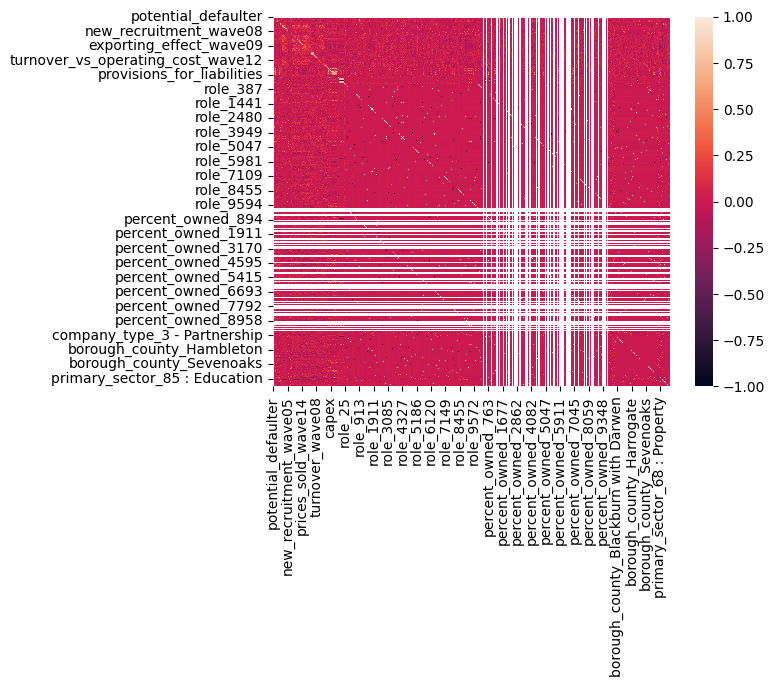

In [259]:
#sns.heatmap(cs8_df.corr())

In [291]:
# lkg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


y = cs8_df[['potential_defaulter', 'defaulter', 'cc_potential_defaulter', 'cc_defaulter']].to_numpy().astype(int)
X = cs8_df[cs8_df.columns[5:]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

In [292]:
pd.DataFrame(y_train).value_counts(normalize=True), pd.DataFrame(y_test).value_counts(normalize=True)
#use SMOTE?

(0  1  2  3
 0  0  0  0    0.593750
       1  0    0.270833
 1  0  0  0    0.072917
 0  0  1  1    0.062500
 Name: proportion, dtype: float64,
 0  1  2  3
 0  0  0  0    0.636364
       1  0    0.272727
 1  0  0  0    0.060606
 0  0  1  1    0.030303
 Name: proportion, dtype: float64)

In [ ]:
# PCA or LDA, PCA first

In [ ]:
# Scale

In [ ]:
#

# VQC

# [Grover's Algorithm]

# Conclusion